In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
#from astroquery.mast import Observations
import lightkurve
import celerite
from celerite import terms
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table

In [2]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True

## Importing in 2014 Flares List

In [3]:
flare_table=pd.read_csv('https://raw.githubusercontent.com/jradavenport/GJ1243-Flares/master/data/gj1243_master_flares.tbl',
            skiprows=23,delim_whitespace=True,names=['index of flare start in "gj1243_master_slc.dat"',
                                                   'index of flare stop in "gj1243_master_slc.dat"','t_start','t_stop'
                                                   ,'t_peak','t_rise','t_decay','flux peak',
                                                   'ED','Duration of rise',
                                                   'Duration of decay','Complex flag',
                                                   '# of people that identified flare event exists',
                                                   '# of people that analyzed this month',
                                                   '# of flare template components fit to event'])

In [4]:
t_starts=flare_table.loc[:,'t_start']
t_stops=flare_table.loc[:,'t_stop']
flux_peak = flare_table.loc[:,'flux peak']
complex_flag = flare_table['Complex flag'] #2=complex, 1 = classical
ED = flare_table['ED'] #units=seconds
flare_table['Flare_Duration'] = 1440.*(t_stops-t_starts) #units = minutes

In [5]:
# Separating the types of flares
classical = len([i for i in complex_flag if i < 2.0]) 
print ("The number of classical flares : " + str(classical)) 

cmplx = len([i for i in complex_flag if i > 1.0]) 
print ("The number of complex flares : " + str(cmplx)) 

complex_flares = flare_table[flare_table['Complex flag'] == 2.0]
classical_flares = flare_table[flare_table['Complex flag'] == 1.0]

#-----------------------------------------------------------------------------------------
min_dur = 20.0 #minutes
max_dur = 75.0

dur_limit = len([i for i in flare_table['Flare_Duration'] if i >= min_dur and i<max_dur]) 
print ("The number of total flares with a duration between 20-75min : " + str(dur_limit))

#------------------------------------------------------------------------------------------
#adding in a column that is the flare duration into the table 
classical_flares['Flare_Duration'] = 1440.*(classical_flares['t_stop'] - classical_flares['t_start'])
#classical_flares

print (len([i for i in classical_flares['Flare_Duration'] if i >= min_dur and i < max_dur]))

#------------------------------------------------------------------------------------------

#Table of Classical flares that are between 20-75 minutes as defined in Davenport(2014)

timed_classical = classical_flares[(classical_flares['Flare_Duration'] >= min_dur) & (classical_flares['Flare_Duration'] < max_dur)]
print(len(timed_classical))

The number of classical flares : 5162
The number of complex flares : 945
The number of total flares with a duration between 20-75min : 1641
902
902


/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Vetted Flares List

In [6]:
new_flares=pd.read_csv('/Users/lupitatovar/flares/notebooks/flare_diagnostics/flare_diagnostics.csv',
            delim_whitespace=True,names=["Flare_Number","Type","Notes"])

In [260]:
vetting2=pd.read_csv('/Users/lupitatovar/local_flares/notebooks/flare_diagnostics2/flare_diagnostics2_wcsv.csv',
            names=["Flare_Number","Type","Notes",'na','key'],skiprows=1)
flag2 = pd.to_numeric(vetting2["Type"].values, errors='coerce')

In [7]:
flag = pd.to_numeric(new_flares["Type"].values, errors='coerce') #nan = classical , 2= adjust start/stop , 3= remove

In [8]:
# Separating the new set of flares and printing new ammounts of flares

still_classical = len(np.where(np.isnan(flag))[0])
print ("The number of remaining classical flares : " + str(still_classical)) 

toss = len([i for i in flag if i == 3.]) 
print ("The number flares tossed out : " + str(toss)) 

edit = len([i for i in flag if i == 2.]) 
print ("The number of flares who need edited times : " + str(edit)) 


# Creating the data tables of newly classified flares (use these to make stacked flares plot)
edit_times = new_flares[new_flares["Type"].values == '2']
toss_flares = new_flares[new_flares["Type"].values == '3']
still_classic_flares = new_flares[pd.isnull(new_flares["Type"].values)]

#includes falres that need start/stop times edited
keep_flares = edit_times.combine_first(still_classic_flares)

The number of remaining classical flares : 476
The number flares tossed out : 341
The number of flares who need edited times : 83


In [258]:
#flag2

In [262]:
# Separating the new set of flares and printing new ammounts of flares

still_classical2 = len([i for i in flag2 if i == 1.]) 
print ("The number of remaining classical flares : " + str(still_classical2)) 

more_complex = len([i for i in flag2 if i == 3.]) 
print ("The number flares tossed out : " + str(more_complex)) 

edit2 = len([i for i in flag2 if i == 2.]) 
print ("The number of flares who need edited times : " + str(edit2)) 


# Creating the data tables of newly classified flares (use these to make stacked flares plot)
edit_times2 = vetting2[vetting2["Type"].values == 2.]
toss_flares2 = vetting2[vetting2["Type"].values == 3.]
still_classic_flares2 = vetting2[vetting2["Type"].values == 1.]

#includes flares that need start/stop times edited
keep_flares_v2 = edit_times2.combine_first(still_classic_flares2)

The number of remaining classical flares : 266
The number flares tossed out : 233
The number of flares who need edited times : 37


In [263]:
keep_flares_v2

Flare_Number  Type                   Notes  na  key
1             1.0   1.0                     NaN NaN  NaN
2             2.0   2.0                     NaN NaN  NaN
5             5.0   1.0                 ask Jim NaN  NaN
6             6.0   1.0       model doesn't fit NaN  NaN
7             7.0   1.0  maybe complex at tail? NaN  NaN
..            ...   ...                     ...  ..  ...
550         550.0   1.0               flat line NaN  NaN
551         551.0   1.0                     NaN NaN  NaN
554         554.0   1.0                     NaN NaN  NaN
556         556.0   1.0                     NaN NaN  NaN
557         557.0   1.0                     NaN NaN  NaN

[303 rows x 5 columns]

In [9]:
#adding index column to Jim's original timed_calssical flares list
timed_classical['Index'] = np.arange(len(timed_classical))
#timed_classical

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
#cross matching the two lists to get new table that has all the flare info!

cross_match = pd.merge(left=timed_classical, right=keep_flares, left_on='Index', right_on='Flare_Number')

#cross_match


In [264]:
cross_match2 = pd.merge(left=timed_classical, right=keep_flares_v2, left_on='Index', right_on='Flare_Number')

In [11]:
toss = pd.merge(left=timed_classical, right=toss_flares, left_on='Index', right_on='Flare_Number')
toss.shape
#toss

(341, 20)

In [265]:
cross_match2

index of flare start in "gj1243_master_slc.dat"  \
0                                              594.0   
1                                             1262.0   
2                                             2438.0   
3                                             2475.0   
4                                             2565.0   
..                                               ...   
298                                         233014.0   
299                                         233574.0   
300                                         234145.0   
301                                         235469.0   
302                                         235919.0   

     index of flare stop in "gj1243_master_slc.dat"      t_start       t_stop  \
0                                             614.0   539.865967   539.880249   
1                                            1288.0   540.326416   540.344788   
2                                            2459.0   541.142456   541.156738   
3                                            2517.0   541.167664   541.196899   
4                                            2587.0   541.229614   541.245300   
..                                              ...          ...          ...   
298                                        233039.0  1115.522827  1115.540527   
299                                        233593.0  1115.936890  1115.951172   
300                                        234165.0  1116.423218  1116.437500   
301                                        235512.0  1119.486084  1119.516724   
302                                        235944.0  1119.797363  1119.815063   

          t_peak    t_rise   t_decay  flux peak         ED  Duration of rise  \
0     539.870056  0.004089  0.010193   0.004795   0.978497          0.187819   
1     540.328491  0.002075  0.016296   0.002447   1.303812          0.137945   
2     541.144470  0.002014  0.012268   0.006591   2.378301          0.567651   
3     541.173096  0.005432  0.023804   0.010578   4.931096          1.413226   
4     541.232361  0.002747  0.012940   0.005510   1.937838          0.650844   
..           ...       ...       ...        ...        ...               ...   
298  1115.525513  0.002685  0.015015   0.015606   4.351948          0.896782   
299  1115.938232  0.001343  0.012940   0.024651   5.440639          1.520191   
300  1116.424561  0.001343  0.012940   0.017358   4.025050          1.019865   
301  1119.489502  0.003418  0.027222   0.147704  38.017441          9.287478   
302  1119.800049  0.002685  0.015015   0.013377   4.464341          1.349631   

     ...  # of people that identified flare event exists  \
0    ...                                             8.0   
1    ...                                             5.0   
2    ...                                             8.0   
3    ...                                             8.0   
4    ...                                             8.0   
..   ...                                             ...   
298  ...                                             6.0   
299  ...                                             6.0   
300  ...                                             6.0   
301  ...                                             6.0   
302  ...                                             6.0   

     # of people that analyzed this month  \
0                                     8.0   
1                                     8.0   
2                                     8.0   
3                                     8.0   
4                                     8.0   
..                                    ...   
298                                   6.0   
299                                   6.0   
300                                   6.0   
301                                   6.0   
302                                   6.0   

     # of flare template components fit to event  Flare_Duration  Index  \
0                                            1.0       20.566

### Importing in GJ1243 light curve (DR-25)

In [12]:
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile
target = '9726699'
gj1243_collection = search_lightcurvefile(target,cadence='short').download_all()

gj1243lc = gj1243_collection[0].PDCSAP_FLUX.remove_nans()

#stitching together the full light curve
for q in range(1,len(gj1243_collection)):
    try:
        gj1243lc = gj1243lc.append(gj1243_collection[q].PDCSAP_FLUX).remove_nans()
    except:
            print(q)

0 (46806, 7)
1 (42289, 7)
2 (32946, 7)
3 (39984, 7)
4 (44060, 7)
5 (34037, 7)
6 (45254, 7)
7 (39630, 7)
8 (43978, 7)
9 (45006, 7)
10 (39121, 7)


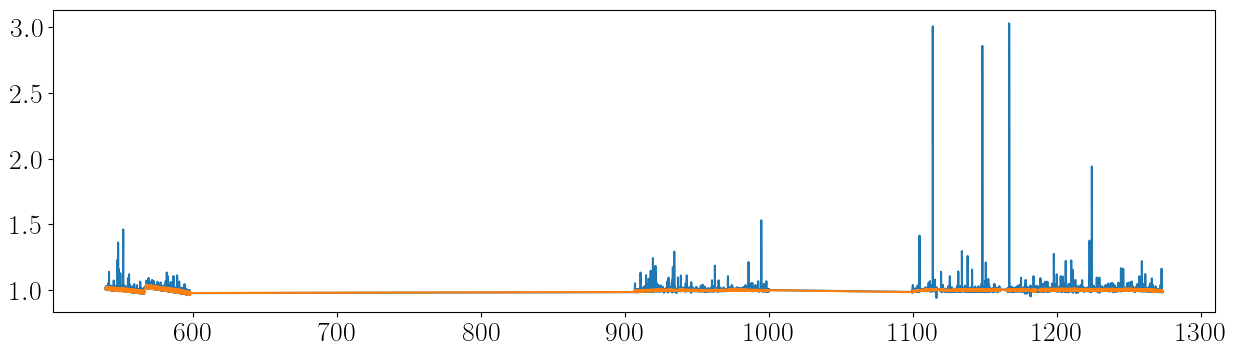

In [13]:
#Reading in the 11 mo gp files
from glob import glob

gp_files = glob('*11mo_*.csv')

for k in range(len(gp_files)): 
    df_tmp = pd.read_csv(gp_files[k]) 
    print(k, df_tmp.shape) 
    if k==0: 
        df = df_tmp 
    else: 
         df = df.append(df_tmp) 

df = df.sort_values(by='time')

plt.figure(figsize=(15,4))
plt.plot(df['time'], df['detrended_flux'])
plt.plot(df['time'], df['mean'])
plt.show()


In [14]:
#dropping the nans in the table
df = df.dropna()
df = df.reset_index(drop=True)
print(len(df))

453111


Text(0.5, 0, 'Time - 2457000 [BTJD days]')

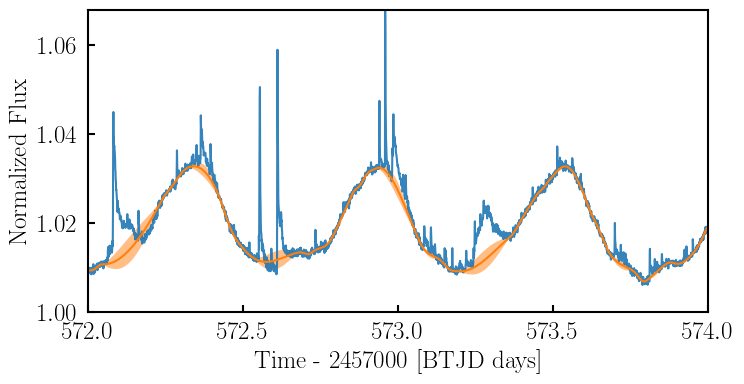

In [15]:

#rcParams["savefig.dpi"] = 300
#rcParams["figure.dpi"] = 100
rcParams["font.size"] = 18
#rcParams["figure.figsize"] = [8, 4]
#rcParams["font.family"] = "sans-serif"
#rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
#rcParams["text.usetex"] = True

plt.figure(figsize=[8,4])

color = "#ff7f0e"

plt.rcParams['axes.linewidth']=1.5
#plt.rcParams['xtick.major.width'] = 1.5
#plt.rcParams['ytick.major.width'] = 1.5
#plt.rc('xtick.major', size=6, pad=5)
plt.tick_params(direction='in',width=1.5,length=5,pad=7)

plt.xticks(np.arange(572,574.5, step=0.5))


plt.plot(df['time'], df['detrended_flux'],alpha=0.9)
plt.plot(df['time'], df['mean'])
plt.fill_between(df['time'], df['mean']+df['std'], df['mean']-df['std'],color=color, alpha=0.5,
                 edgecolor="none",label='gp')

plt.xlim(572,574)
#plt.xlim(914,916)
plt.ylim(1,1.068)
plt.ylabel("Normalized Flux")
plt.xlabel("Time - 2457000 [BTJD days]")

#plt.savefig('/Users/lupitatovar/flares/figures/gp_overlay.png',bbox_inches='tight')

#plt.show()

In [16]:
detrended = df['detrended_flux'].values - df['mean'].values
print(detrended)

[ 0.00214614  0.00080994  0.00056504 ... -0.00054118 -0.00070254
 -0.0002242 ]


In [17]:
#timed_classical
classic_start=timed_classical.loc[:,'t_start'].values
classic_stop=timed_classical.loc[:,'t_stop'].values
classic_dur = timed_classical.loc[:,'Flare_Duration'].values
#print(classic_start)

In [18]:
#timed_classical

## Putting everything into a loop to stack all flares

Variables being calculated for the flare model: center time, scale height, scale duration

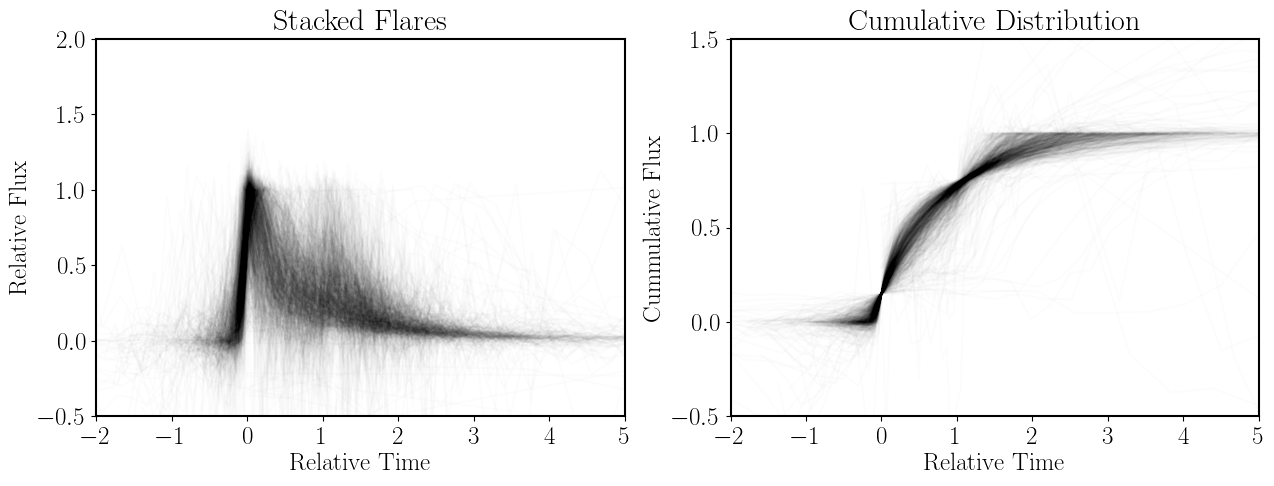

In [18]:
fig, axs = plt.subplots(1,2, figsize=(15, 5), facecolor='w', edgecolor='k')

t_center = np.array([])          # time at 50% cummulative flux of each flare
scale_height = np.array([])  # mean flux of the entire flare 
scale_dur = np.array([])     # (t_75 - t_25)


for i in range(0,len(timed_classical)):

    #Mask of the times (t_start and t_stop) between each flare 
    temp = np.where((df['time'] < timed_classical['t_stop'].values[i]) & 
                    (df['time'] > timed_classical['t_start'].values[i]))[0]
    
    # cummulative distribution of detrended fluxes within each flare
    cd_detrended = np.cumsum((detrended[temp])/np.sum(detrended[temp]))
    

    # interpolation over the flux of each flare: yvals are percentiles of cummulative flux & x_interp gives corresponding times
    # note that we are looking at times and fluxes in cummulative space
    
    yvals = np.array([0.15,0.25,0.75])
    xinterp = np.interp(yvals, cd_detrended, df['time'][temp])

    # t_50
    #cd_i_max = np.argmax(detrended[temp])
    #t_max = (df['time'].values[temp][cd_i_max])
    #cd_flux_max = (detrended[temp][cd_i_max])
    
    
    #double check this part
    t1 = xinterp[0]
    t2 = xinterp[1]#cd_flux_max / 2.0
    t3 = xinterp[2]
    
    t_center = np.append(t_center,t1)
    
    #i_xs = np.where((xinterp[temp] > t_50_flux[i]))[0]
    #time_xs = yvals[temp][i_xs]
    
    # defining the scale height
    cd_mean = np.cumsum(detrended[temp])    #explore this a little more (have tried mean, sum, median)
    #scale_height = np.append(scale_height,cd_mean)
    
    
    #testing interpolating over the fluxes instead of using mean flux
    height_interp = np.interp(0.99, np.linspace(0,1,len(detrended[temp])), np.sort(detrended[temp]))
    scale_height = np.append(scale_height,height_interp)
    
    # scale duration

    diff_dur = np.abs(t3 - t2)
    scale_dur = np.append(scale_dur,diff_dur)
    
    
    ######## PLOTTING ################

    cd_x = (df['time'][temp] - t_center[i])/(scale_dur[i])
    cd_y = ((detrended[temp])/(scale_height[i]))

    
    #ax1.plot(xinterp,yvals,'o',color='orange', label= 'interp data')

    axs[0].plot(cd_x,cd_y,color='k',alpha=0.01)

    #axs[1].plot((xinterp[2]-xinterp)/scale_dur[i],yvals,'x',color='orange',alpha=0.2)
    #axs[1].plot((df['time'][temp])/scale_dur[i],cd_detrended,color='k',alpha=0.2)
    axs[1].plot(cd_x,np.cumsum(cd_y)/np.sum(cd_y),color='k',alpha=0.01)
    #axs[1].scatter(df['time'][i]-xinterp[2],cd_detrended[i],color='k')#,alpha=0.5)
   

    #Setting Titles
    axs[0].set_title('Stacked Flares')
    axs[1].set_title('Cumulative Distribution')
    

    #Axes labels
    axs[0].set_xlabel("Relative Time")
    axs[0].set_ylabel("Relative Flux")    
    axs[1].set_ylabel("Cummulative Flux")
    axs[1].set_xlabel("Relative Time")

    #Axes limits
    axs[0].set_xlim(-2,5)
    axs[0].set_ylim(-0.5,2) 
    
    axs[1].set_xlim(-2,5)
    axs[1].set_ylim(-.5,1.5)
    #Legend
    #ax1.legend(loc='lower right')

    
    #plt.xlim(-2,5)
    #plt.ylim(-0.5,2)
    # cumulative distribution plot of the flares
    
    #plt.plot((xinterp - xinterp[1])/scale_dur[i],yvals,'x',color='orange')
    #plt.scatter(df['time'][i]- xinterp[2],cd_detrended[i])
    #plt.plot((df['time'][temp]- xinterp[1])/scale_dur[i],cd_detrended)
    #plt.xlabel("Time")
    #plt.ylabel("Flux")


## Stacked flares with newly vetted flare list

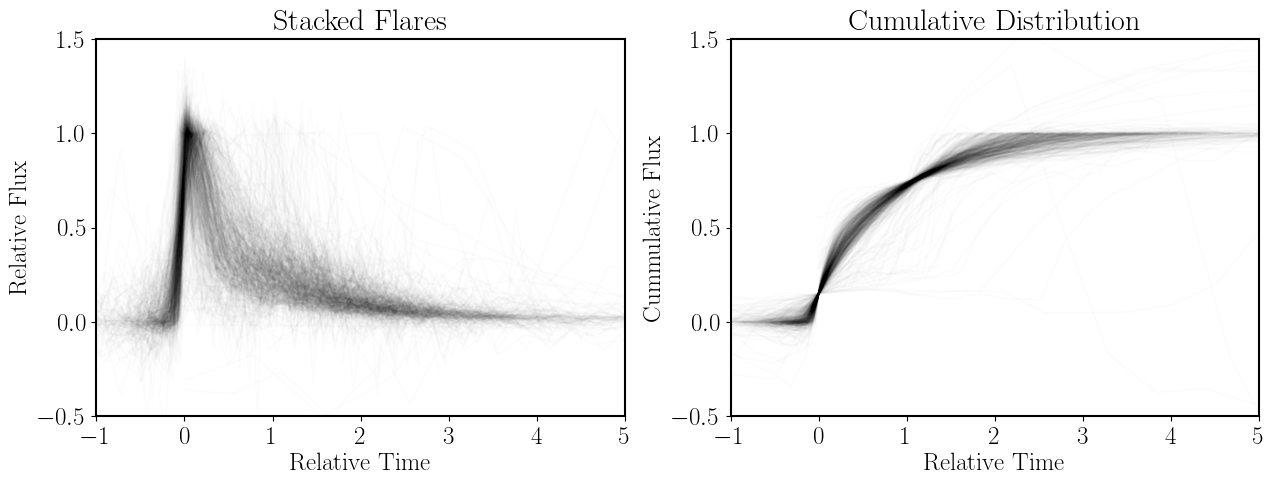

In [19]:
fig, axs = plt.subplots(1,2, figsize=(15, 5), facecolor='w', edgecolor='k')

new_t_center = np.array([])          # time at 50% cummulative flux of each flare
new_scale_height = np.array([])  # mean flux of the entire flare 
new_scale_dur = np.array([])     # (t_75 - t_25)

#arrays that get saved into .csv
new_x_all=np.array([])
new_y_all=np.array([])
new_y_err=np.array([])
new_gp_st_dev=np.array([])

for i in range(0,len(cross_match)):

    #Mask of the times (t_start and t_stop) between each flare 
    temp1 = np.where((df['time'] < cross_match['t_stop'].values[i]) & 
                    (df['time'] > cross_match['t_start'].values[i]))[0]
    
    # cummulative distribution of detrended fluxes within each flare
    cd_detrended1 = np.cumsum((detrended[temp1])/np.sum(detrended[temp1]))
    

    # interpolation over the flux of each flare: yvals are percentiles of cummulative flux & x_interp gives corresponding times
    # note that we are looking at times and fluxes in cummulative space
    
    yvals = np.array([0.15,0.25,0.75])
    new_xinterp = np.interp(yvals, cd_detrended1, df['time'][temp1])

    # t_50
    #cd_i_max = np.argmax(detrended[temp])
    #t_max = (df['time'].values[temp][cd_i_max])
    #cd_flux_max = (detrended[temp][cd_i_max])
    
    
    #double check this part
    t1 = new_xinterp[0]
    t2 = new_xinterp[1]#cd_flux_max / 2.0
    t3 = new_xinterp[2]
    
    new_t_center = np.append(new_t_center,t1)
    
    #i_xs = np.where((xinterp[temp] > t_50_flux[i]))[0]
    #time_xs = yvals[temp][i_xs]
    
    # defining the scale height
    cd_mean1 = np.cumsum(detrended[temp1])    #explore this a little more (have tried mean, sum, median)
    #scale_height = np.append(scale_height,cd_mean)
    
    
    #testing interpolating over the fluxes instead of using mean flux
    height_interp = np.interp(0.99, np.linspace(0,1,len(detrended[temp1])), np.sort(detrended[temp1]))
    new_scale_height = np.append(new_scale_height,height_interp)
    
    # scale duration

    diff_dur = np.abs(t3 - t2)
    new_scale_dur = np.append(new_scale_dur,diff_dur)
    
    
    ######## PLOTTING ################

    new_x = (df['time'][temp1] - new_t_center[i])/(new_scale_dur[i])
    new_y = ((detrended[temp1])/(new_scale_height[i]))
    
    
    
    #ax1.plot(xinterp,yvals,'o',color='orange', label= 'interp data')

    axs[0].plot(new_x,new_y,color='k',alpha=0.01)


    #axs[1].plot((xinterp[2]-xinterp)/new_scale_dur[i],yvals,'x',color='orange',alpha=0.2)
    axs[1].plot(new_x,np.cumsum(new_y)/np.sum(new_y),color='k',alpha=0.01)
    
    #axs[1].scatter(df['time'][i]-xinterp[2],cd_detrended[i],color='k')#,alpha=0.5)
   

    #Setting Titles
    axs[0].set_title('Stacked Flares')
    axs[1].set_title('Cumulative Distribution')
    

    #Axes labels
    axs[0].set_xlabel("Relative Time")
    axs[0].set_ylabel("Relative Flux")    
    axs[1].set_ylabel("Cummulative Flux")
    axs[1].set_xlabel("Relative Time")

    #Axes limits
    axs[0].set_xlim(-1,5)
    axs[0].set_ylim(-0.5,1.5) 
    
    axs[1].set_xlim(-1,5)
    axs[1].set_ylim(-.5,1.5)
    #Legend
    #ax1.legend(loc='lower right')

    ########### Saving Arrays ########################
    
    # time array
    new_x_all = np.append(new_x_all,new_x)
        
    #Flux Array
    new_y_all = np.append(new_y_all,new_y)
        
       
        
        #    
    #i_max = np.argmax(detrended[temp])
    #flux_max = (detrended[temp][i_max])
    #new_peaks = np.append(new_peaks,flux_max)
        
    #Flux Errors
    
    new_flux_err = df['df_flux_err'][temp1].values/new_scale_height[i] #should this be divided by peak flux not scale height?
    new_y_err = np.append(new_y_err,new_flux_err)
        
    #GP Standard Deviation
    
    new_st_dev = df['std'][temp1].values/new_scale_height[i]
    new_gp_st_dev = np.append(new_gp_st_dev,new_st_dev)   
    #plt.savefig('stack_cd.png',bbox_inches='tight')

Cross match round2

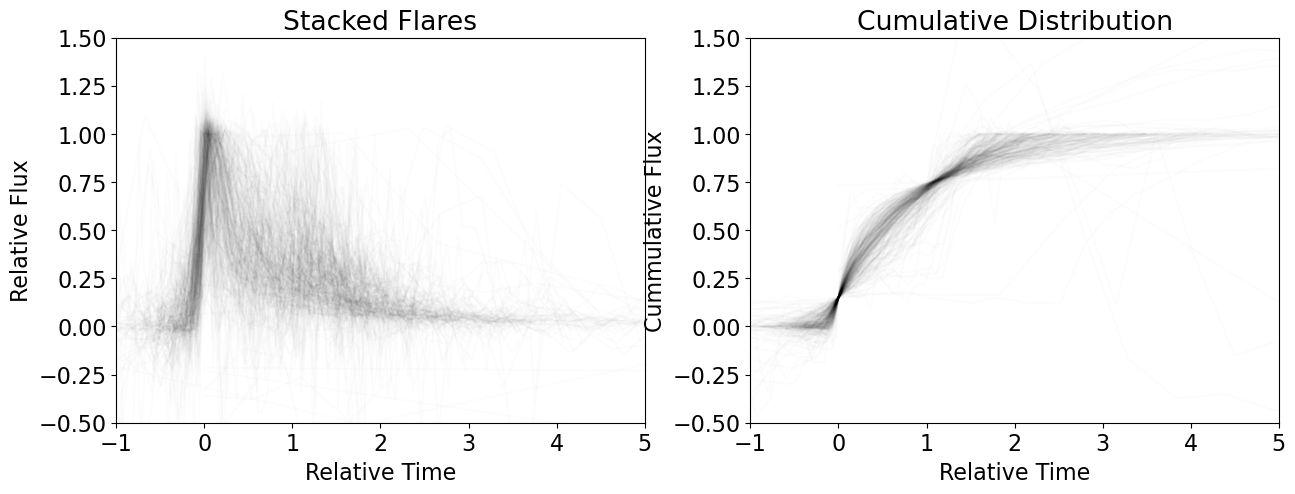

In [266]:
fig, axs = plt.subplots(1,2, figsize=(15, 5), facecolor='w', edgecolor='k')

new_t_center2 = np.array([])          # time at 50% cummulative flux of each flare
new_scale_height2 = np.array([])  # mean flux of the entire flare 
new_scale_dur2 = np.array([])     # (t_75 - t_25)

#arrays that get saved into .csv
new_x_all2=np.array([])
new_y_all2=np.array([])
new_y_err2=np.array([])
new_gp_st_dev2=np.array([])

for i in range(0,len(cross_match2)):

    #Mask of the times (t_start and t_stop) between each flare 
    temp1 = np.where((df['time'] < cross_match2['t_stop'].values[i]) & 
                    (df['time'] > cross_match2['t_start'].values[i]))[0]
    
    # cummulative distribution of detrended fluxes within each flare
    cd_detrended1 = np.cumsum((detrended[temp1])/np.sum(detrended[temp1]))
    

    # interpolation over the flux of each flare: yvals are percentiles of cummulative flux & x_interp gives corresponding times
    # note that we are looking at times and fluxes in cummulative space
    
    yvals = np.array([0.15,0.25,0.75])
    new_xinterp = np.interp(yvals, cd_detrended1, df['time'][temp1])

    # t_50
    #cd_i_max = np.argmax(detrended[temp])
    #t_max = (df['time'].values[temp][cd_i_max])
    #cd_flux_max = (detrended[temp][cd_i_max])
    
    
    #double check this part
    t1 = new_xinterp[0]
    t2 = new_xinterp[1]#cd_flux_max / 2.0
    t3 = new_xinterp[2]
    
    new_t_center2 = np.append(new_t_center2,t1)
    
    #i_xs = np.where((xinterp[temp] > t_50_flux[i]))[0]
    #time_xs = yvals[temp][i_xs]
    
    # defining the scale height
    cd_mean1 = np.cumsum(detrended[temp1])    #explore this a little more (have tried mean, sum, median)
    #scale_height = np.append(scale_height,cd_mean)
    
    
    #testing interpolating over the fluxes instead of using mean flux
    height_interp = np.interp(0.99, np.linspace(0,1,len(detrended[temp1])), np.sort(detrended[temp1]))
    new_scale_height2 = np.append(new_scale_height2,height_interp)
    
    # scale duration

    diff_dur = np.abs(t3 - t2)
    new_scale_dur2 = np.append(new_scale_dur2,diff_dur)
    
    
    ######## PLOTTING ################

    new_x2 = (df['time'][temp1] - new_t_center2[i])/(new_scale_dur2[i])
    new_y2 = ((detrended[temp1])/(new_scale_height2[i]))
    
    
    
    #ax1.plot(xinterp,yvals,'o',color='orange', label= 'interp data')

    axs[0].plot(new_x2,new_y2,color='k',alpha=0.01)


    #axs[1].plot((xinterp[2]-xinterp)/new_scale_dur[i],yvals,'x',color='orange',alpha=0.2)
    axs[1].plot(new_x2,np.cumsum(new_y2)/np.sum(new_y2),color='k',alpha=0.01)
    
    #axs[1].scatter(df['time'][i]-xinterp[2],cd_detrended[i],color='k')#,alpha=0.5)
   

    #Setting Titles
    axs[0].set_title('Stacked Flares')
    axs[1].set_title('Cumulative Distribution')
    

    #Axes labels
    axs[0].set_xlabel("Relative Time")
    axs[0].set_ylabel("Relative Flux")    
    axs[1].set_ylabel("Cummulative Flux")
    axs[1].set_xlabel("Relative Time")

    #Axes limits
    axs[0].set_xlim(-1,5)
    axs[0].set_ylim(-0.5,1.5) 
    
    axs[1].set_xlim(-1,5)
    axs[1].set_ylim(-.5,1.5)
    #Legend
    #ax1.legend(loc='lower right')

    ########### Saving Arrays ########################
    
    # time array
    new_x_all2 = np.append(new_x_all2,new_x2)
        
    #Flux Array
    new_y_all2 = np.append(new_y_all2,new_y2)
        
       
        
        #    
    #i_max = np.argmax(detrended[temp])
    #flux_max = (detrended[temp][i_max])
    #new_peaks = np.append(new_peaks,flux_max)
        
    #Flux Errors
    
    new_flux_err2 = df['df_flux_err'][temp1].values/new_scale_height2[i] #should this be divided by peak flux not scale height?
    new_y_err2 = np.append(new_y_err2,new_flux_err2)
        
    #GP Standard Deviation
    
    new_st_dev2 = df['std'][temp1].values/new_scale_height2[i]
    new_gp_st_dev2 = np.append(new_gp_st_dev2,new_st_dev2)   
    #plt.savefig('stack_cd.png',bbox_inches='tight')

In [286]:
print(len(new_x_all))
print(len(new_y_all))

print(len(cross_match))
print(len(new_x_all2))
print(len(new_y_all2))

print(len(cross_match2))
#print(558*26)
#plt.plot(new_x_all,(new_y_all))

18576
18576
558
9649
9649
303


### Overlaying a running median for stacked flares plot

Text(0, 0.5, 'Relative Flux')

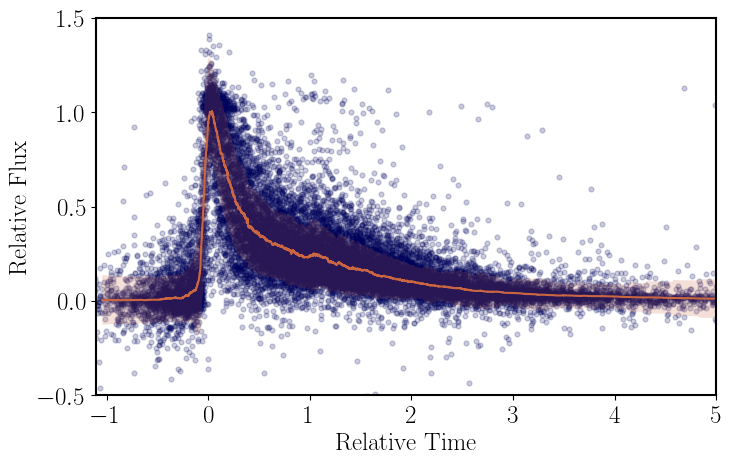

In [20]:

new_sort = np.argsort(new_x_all)
example_median=pd.Series(new_y_all[new_sort]).rolling(500, center=True).median()
example_std = pd.Series(new_y_all[new_sort]).rolling(500, center=True).std()


plt.scatter(new_x_all[new_sort],new_y_all[new_sort],color='#00035b',s=12,alpha=0.2)
#axs[0].plot(new_x.rolling(2).median(),new_y,color='red')


plt.plot(new_x_all[new_sort],example_median,color='#ca6641',lw=1.5)

plt.fill_between(new_x_all[new_sort], example_median+example_std, example_median-example_std,color='#ca6641', alpha=0.2,
                 edgecolor="none")


#plt.plot(new_x_all[new_sort],example_median+example_std,color='C0',alpha=0.5)
#plt.plot(new_x_all[new_sort],example_median-example_std,color='C0',alpha=0.5)
plt.xlim(-1.1,5)
plt.ylim(-0.5,1.5)

plt.xlabel("Relative Time")
plt.ylabel("Relative Flux") 

(-0.5, 1.5)

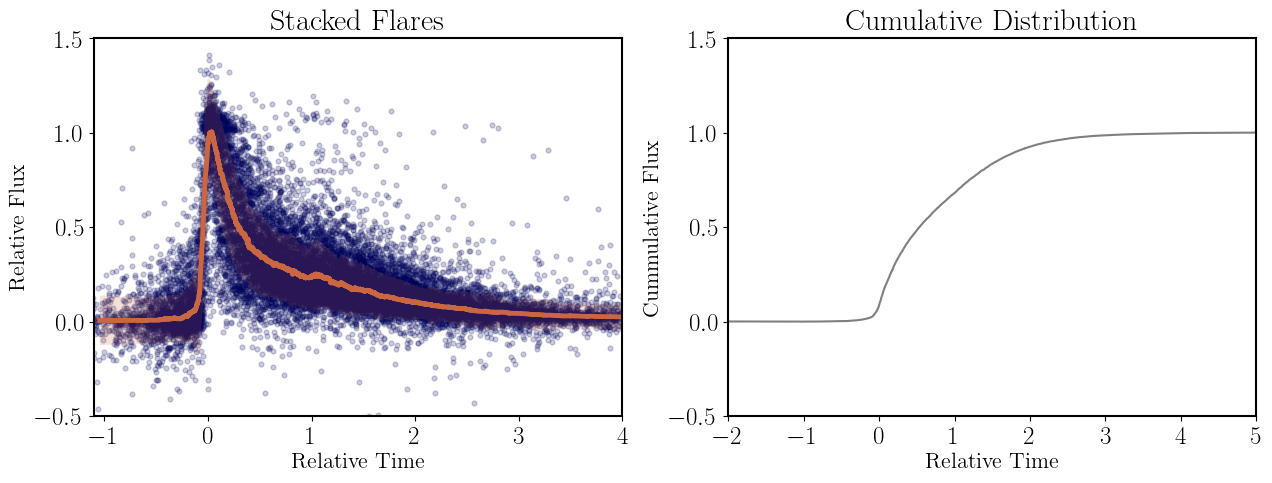

In [21]:


fig, axs = plt.subplots(1,2, figsize=(15, 5), facecolor='w', edgecolor='k')


axs[0].scatter(new_x_all[new_sort],new_y_all[new_sort],color='#00035b',alpha=0.2,s=12)
#axs[0].plot(new_x.rolling(2).median(),new_y,color='red')


axs[0].plot(new_x_all[new_sort],example_median,color='#ca6641',lw=3.5)

axs[0].fill_between(new_x_all[new_sort], example_median+example_std, example_median-example_std,color='#ca6641', alpha=0.2,
                 edgecolor="none")

axs[1].plot(new_x_all[new_sort],np.cumsum(new_y_all[new_sort])/np.sum(new_y_all[new_sort]),color='k',alpha=0.5)
    

    #Setting Titles
axs[0].set_title('Stacked Flares')
axs[1].set_title('Cumulative Distribution')
    

    #Axes labels
axs[0].set_xlabel("Relative Time",fontsize=16)
axs[0].set_ylabel("Relative Flux",fontsize=16)    
axs[1].set_ylabel("Cummulative Flux",fontsize=16)
axs[1].set_xlabel("Relative Time",fontsize=16)

    #Axes limits
axs[0].set_xlim(-1.1,4)
axs[0].set_ylim(-0.5,1.5) 
    
axs[1].set_xlim(-2,5)
axs[1].set_ylim(-.5,1.5)
    #Legend
    #ax1.legend(loc='lower right')


### Overplotting Jim's flare model onto this w/ amp=1,t_half=1,peak=0
https://github.com/jradavenport/appaloosa/blob/master/appaloosa/aflare.py

In [22]:
from scipy.stats import binned_statistic

def aflare1(t, tpeak, fwhm, ampl, upsample=False, uptime=10):
    '''
    The Analytic Flare Model evaluated for a single-peak (classical).
    Reference Davenport et al. (2014) http://arxiv.org/abs/1411.3723
    Use this function for fitting classical flares with most curve_fit
    tools.
    Note: this model assumes the flux before the flare is zero centered
    Parameters
    ----------
    t : 1-d array
        The time array to evaluate the flare over
    tpeak : float
        The time of the flare peak
    fwhm : float
        The "Full Width at Half Maximum", timescale of the flare
    ampl : float
        The amplitude of the flare
    upsample : bool
        If True up-sample the model flare to ensure more precise energies.
    uptime : float
        How many times to up-sample the data (Default is 10)
    Returns
    -------
    flare : 1-d array
        The flux of the flare model evaluated at each time
    '''
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]

    if upsample:
        dt = np.nanmedian(np.diff(t))
        timeup = np.linspace(min(t)-dt, max(t)+dt, t.size * uptime)

        flareup = np.piecewise(timeup, [(timeup<= tpeak) * (timeup-tpeak)/fwhm > -1.,
                                        (timeup > tpeak)],
                                    [lambda x: (_fr[0]+                       # 0th order
                                                _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                                _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                                _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                                _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                                     lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                                _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                                    ) * np.abs(ampl) # amplitude

        # and now downsample back to the original time...
        ## this way might be better, but makes assumption of uniform time bins
        # flare = np.nanmean(flareup.reshape(-1, uptime), axis=1)

        ## This way does linear interp. back to any input time grid
        # flare = np.interp(t, timeup, flareup)

        ## this was uses "binned statistic"
        downbins = np.concatenate((t-dt/2.,[max(t)+dt/2.]))
        flare,_,_ = binned_statistic(timeup, flareup, statistic='mean',
                                 bins=downbins)

    else:
        flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
                                 (t > tpeak)],
                                [lambda x: (_fr[0]+                       # 0th order
                                            _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                            _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                            _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                            _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                                 lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                            _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                                ) * np.abs(ampl) # amplitude

    return flare

#### Loading in arrays from .csv so that we don't need to re-run the loop above

 The arrays below contain time, flux, flux_err, and standard deviation for each flare
 stack_arrays_vet2 is the file that contains the latest values of vetted flares (total of 302 flares that are classical and also includes 37 that need start/stop times to be edited)

In [267]:

#dict_n = {'time':new_x_all2,'flux': new_y_all2, 'flux_err': new_y_err2, 'gp_st_dev': new_gp_st_dev2} 
#stack_arrays_vet2 = pd.DataFrame(data=dict_n) 
#stack_arrays_vet2.to_csv(r'stack_arrays_vet2.csv',header=True,index=True)

In [26]:
#dict_n = {'time':new_x_all,'flux': new_y_all, 'flux_err': new_y_err, 'gp_st_dev': new_gp_st_dev} 
#new_stacking_arrays = pd.DataFrame(data=dict_n) 
#new_stacking_arrays.to_csv(r'new_stacking_array_values.csv',header=True,index=True)

In [23]:
#load in the arrays (no need to re-run the for loop above)

new_stacking_arrays=pd.read_csv('new_stacking_array_values.csv')

(-5.0, 10.0)

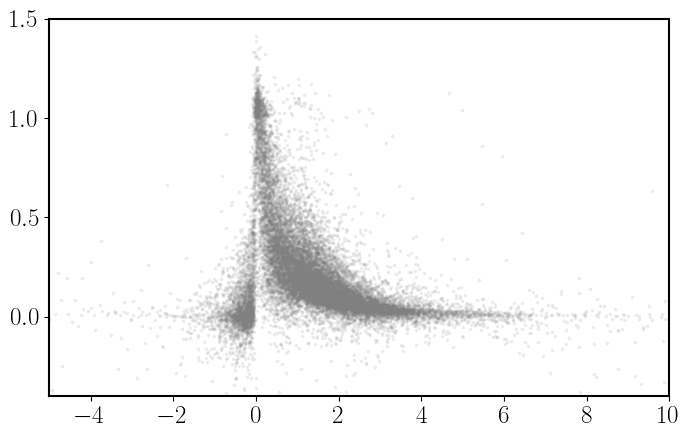

In [24]:
time = new_stacking_arrays['time'].values
flux = new_stacking_arrays['flux'].values
flux_err = new_stacking_arrays['flux_err'].values
gp_err = new_stacking_arrays['gp_st_dev'].values
both_errors = np.sqrt( (flux_err)**2 + (gp_err)**2 )

ns_all = np.argsort(time)
plt.scatter(time[ns_all],flux[ns_all],alpha=.1,s=10,marker='.',color='grey')
plt.ylim(-0.4,1.5)
plt.xlim(-5,10)

(-1.0, 5.0)

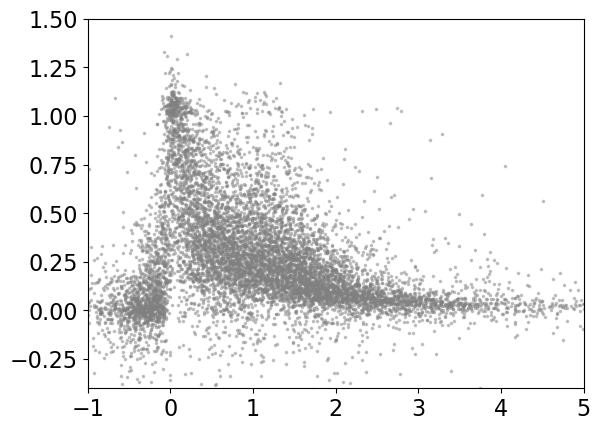

In [287]:
vet2_stack=pd.read_csv('stack_arrays_vet2.csv')
time_v2 = vet2_stack['time'].values
flux_v2 = vet2_stack['flux'].values
flux_err_v2 = vet2_stack['flux_err'].values
gp_err_v2 = vet2_stack['gp_st_dev'].values
both_errors_v2 = np.sqrt( (flux_err_v2)**2 + (gp_err_v2)**2 )

v2_sort = np.argsort(time_v2)
plt.scatter(time_v2[v2_sort],flux_v2[v2_sort],alpha=.4,s=10,marker='.',color='grey')
plt.ylim(-0.4,1.5)
plt.xlim(-1,5)

In [288]:
print((len(time[ns_all])))
print(len(time_v2[v2_sort]))
#print(len(df['df_flux_err'].values))
#print(len(flux_err))

18576
9649


/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in multiply


Text(0, 0.5, 'Relative Flux')

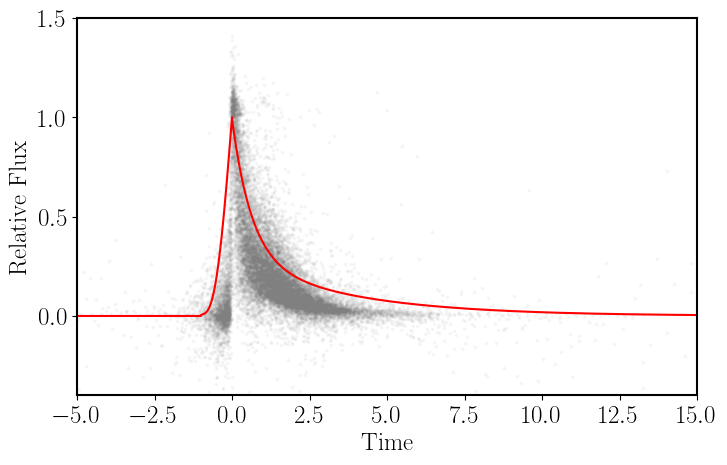

In [25]:

jim_model = aflare1(time,0,1,1)
plt.scatter(time[ns_all],flux[ns_all],alpha=.05,s=10,marker='.',color='grey')

plt.plot(time[ns_all],jim_model[ns_all],color='red')  

plt.ylim(-0.4,1.5)
plt.xlim(-5,15)
plt.xlabel('Time')
plt.ylabel('Relative Flux')

#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in multiply


Text(0, 0.5, 'Relative Flux')

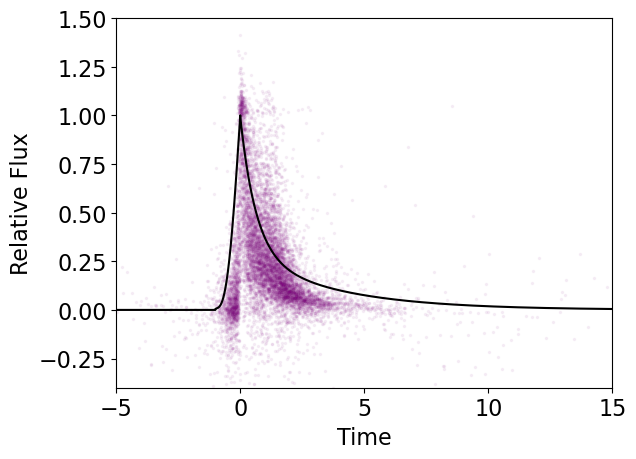

In [290]:
plt.scatter(time_v2[v2_sort],flux_v2[v2_sort],alpha=.05,s=10,marker='.',color='purple')
#plt.scatter(time[ns_all],flux[ns_all],alpha=.05,s=10,marker='.',color='grey')

plt.plot(time_v2[v2_sort],aflare1(time_v2,0,1,1)[v2_sort],color='black')  

plt.ylim(-0.4,1.5)
plt.xlim(-5,15)
plt.xlabel('Time')
plt.ylabel('Relative Flux')

In [31]:
#plot of the gp uncertainty in our detrended data
#plt.scatter(time[ns_all],gp_err[ns_all],alpha=.05,s=10,marker='.')
#plt.ylim(0,0.5)
#plt.xlim(-2,5)

Below is the flux error from the gp. We expect it to be a straight line centered at zero, however there is some variance between 0-0.3

In [ ]:
#plot the rolling mean and y_err

#plt.scatter(time[ns_all],flux_err[ns_all],alpha=.05,s=8,marker='.')
#plt.ylim(0,0.3)
#plt.xlim(-2,5)

In [ ]:
#plotting the variance of the st_dev (which is just the st_dev squared?)
#plt.scatter(time,gp_err**2,alpha=.05,s=10,marker='.')
#plt.ylim(-0.01,.1)
#plt.xlim(-2,5)

Text(0, 0.5, 'Relative Flux')

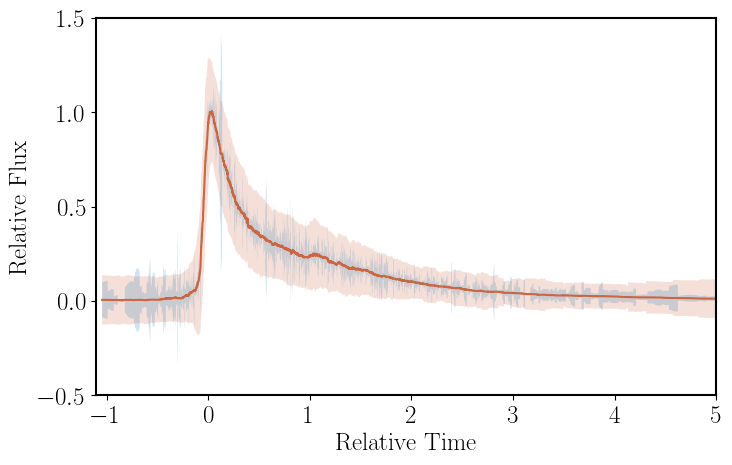

In [26]:


#plt.scatter(time[ns_all],flux[ns_all],color='#00035b',alpha=0.2,s=12)
#axs[0].plot(new_x.rolling(2).median(),new_y,color='red')


plt.plot(time[ns_all],example_median,color='#ca6641',lw=1.5)

#standard deviation of the median values
plt.fill_between(time[ns_all], example_median+example_std, example_median-example_std,color='#ca6641', alpha=0.2,
                 edgecolor="none")

#standard deviation of the median + the combined gp and photometric errors added in quadtrature
plt.fill_between(time[ns_all], example_median+both_errors, example_median-both_errors,color='C0', alpha=0.2,
                 edgecolor="none")




#plt.plot(new_x_all[new_sort],example_median+example_std,color='C0',alpha=0.5)
#plt.plot(new_x_all[new_sort],example_median-example_std,color='C0',alpha=0.5)
plt.xlim(-1.1,5)
plt.ylim(-0.5,1.5)

plt.xlabel("Relative Time")
plt.ylabel("Relative Flux") 

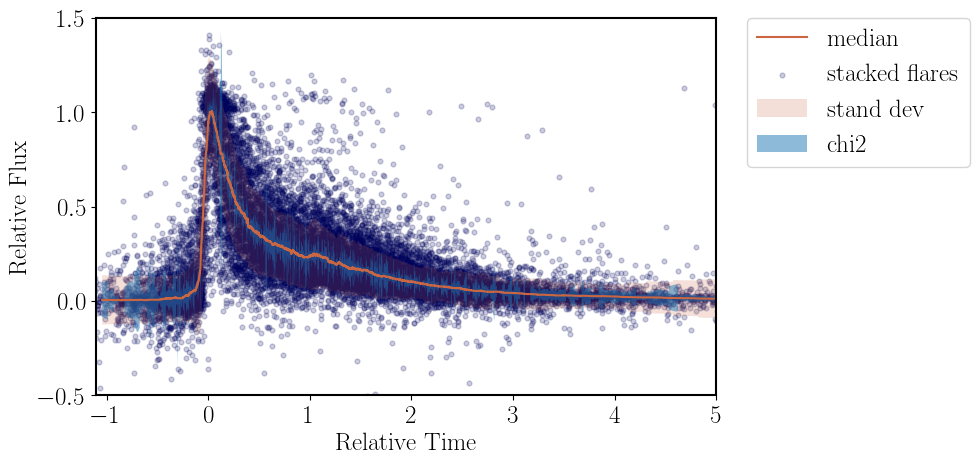

In [27]:
#example_median=pd.Series(new_y_all[new_sort]).rolling(500, center=True).median()
#example_std = pd.Series(new_y_all[new_sort]).rolling(500, center=True).std()

plt.scatter(time[ns_all],flux[ns_all],color='#00035b',alpha=0.2,s=12,label='stacked flares')
#axs[0].plot(new_x.rolling(2).median(),new_y,color='red')


plt.plot(time[ns_all],example_median,color='#ca6641',lw=1.5,label='median')

#standard deviation of the median values
plt.fill_between(time[ns_all], example_median+example_std, example_median-example_std,color='#ca6641', alpha=0.2,
                 edgecolor="none",label='stand dev')

#standard deviation of the median + the combined gp and photometric errors added in quadtrature
plt.fill_between(time[ns_all], example_median+both_errors, example_median-both_errors,color='C0', alpha=0.5,
                 edgecolor="none",label = 'chi2')

plt.xlim(-1.1,5)
plt.ylim(-0.5,1.5)

plt.xlabel("Relative Time")
plt.ylabel("Relative Flux") 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [ ]:
#Taking the median of the errors

''''
plt.plot(time[ns_all],both_errors)


median_of_errors = pd.Series(both_errors[ns_all]).rolling(500, center=True).median()
std_of_errors = pd.Series(both_errors[ns_all]).rolling(500, center=True).std()

plt.plot(time[ns_all],median_of_errors)
plt.fill_between(time[ns_all], median_of_errors+std_of_errors, median_of_errors-std_of_errors,color='#ca6641', alpha=0.2,
                 edgecolor="none")

plt.xlim(-1.1,5)
plt.ylim(-0.5,1.5)

plt.xlabel("Relative Time")
plt.ylabel("Relative Flux") 

In [35]:
#import matplotlib.pyplot as plt
''''
plt.scatter(time[ns_all],flux[ns_all],color='#00035b',alpha=0.2,s=12)

#median of the data (stacked flares)
            
plt.plot(time[ns_all], example_median, color='#ca6641')

#standard deviation of data
plt.fill_between(time[ns_all], example_median+example_std, example_median-example_std,color='#ca6641', alpha=0.2,
                 edgecolor="none")

#median of the errors
plt.plot(time[ns_all],median_of_errors,color='C0')
plt.fill_between(time[ns_all], median_of_errors+std_of_errors, median_of_errors-std_of_errors,color='C0', alpha=0.2,
                 edgecolor="none")


plt.xlim(-1.1,5)
plt.ylim(-0.5,1.5)

plt.xlabel("Relative Time")
plt.ylabel("Relative Flux") 

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-35-5148a7dfba31>, line 23)

### Calculating $ \chi ^2$ 

In [28]:
print(both_errors)

[0.06735671 0.06879949 0.07023016 ... 0.1372603  0.13913251 0.14100222]


In [29]:
xmin = -1
xmax = 5
x_mask = np.where((time[ns_all] > xmin) & (time[ns_all] < xmax))[0]
print(x_mask)

[  263   264   265 ... 17978 17979 17980]


In [30]:
ymin = -0.5
ymax= 1.5

both_mask = np.where((time[ns_all] > xmin) & (time[ns_all] < xmax) & (flux[ns_all] > ymin) & (flux[ns_all] < ymax))[0]
print(len(both_mask))

17714


In [31]:
print(len(both_errors))
print(len(both_errors[x_mask]))

18576
17718


In [32]:
#print('Chi Squared:' + str(np.sum(both_errors)))
#print('Chi Squared between time lim [-1,5]:'+str(np.sum(both_errors[x_mask])))

In [33]:
chi2 = np.sum(((flux[ns_all][x_mask]- example_median[x_mask])/both_errors[ns_all][x_mask])**2)/(len(x_mask))
print('Chi Squared between time lim [-1,5]:' +str(chi2))                                                                                        

Chi Squared between time lim [-1,5]:35.93533158316161


In [34]:
chi2_both = np.sum(((flux[ns_all][both_mask]- example_median[both_mask])/both_errors[ns_all][both_mask])**2)/(len(both_mask))
print('Chi Squared with both_mask:' +str(chi2_both))   

Chi Squared with both_mask:35.91252053729478


Compute chi2 of the data vs the new flare model below:

In [37]:
print(np.nansum(((flux[ns_all][both_mask]- flare_model(time[ns_all],0,1,1.2)[both_mask])/both_errors[ns_all][both_mask])**2)/(len(both_mask)))

551.8367826526974


In [291]:
both_mask_v2 = np.where((time_v2[v2_sort] > xmin) & (time_v2[v2_sort] < xmax) & (flux_v2[v2_sort] > ymin) & (flux_v2[v2_sort] < ymax))[0]
print(len(both_mask_v2))


print(np.nansum(((flux_v2[v2_sort][both_mask_v2]- flare_model(time_v2[v2_sort],0,1,1.2)[both_mask_v2])/both_errors_v2[v2_sort][both_mask_v2])**2)/(len(both_mask_v2)))


9085
244.7603947637945


### Defining the new flare model

In [36]:

from scipy import special
def flare_model(t,tpeak, fwhm, ampl):
    '''
    The Continuous Flare Model evaluated for single-peak (classical) flare events.
    Use this function for fitting classical flares with most curve_fit
    tools.

    References
    --------------
    Reference Davenport et al. (2014) http://arxiv.org/abs/1411.3723
    Jackman et al. (2018)

    Parameters
    ----------
    t : 1-d array
        The time array to evaluate the flare over

    tpeak : float
        The time of the flare peak

    fwhm : float
        The Full Width at Half Maximum, timescale of the flare

    ampl : float
        The amplitude of the flare


    Returns
    -------
    flare : 1-d array
        The flux of the flare model evaluated at each time

        The convolution of a double exponential with a gaussian to give us a continuous flare model
    '''

    t_new = (t-tpeak)/fwhm


    #Values were fit & calculated using MCMC 256 walkers and 10000 steps

    A,B,C,D1,D2,f1 = [2.93019203, 1.78279154, 0.3113989, 0.21181818, 1.63976688, 0.13602386]
    z1 = ((2*B + (C**2 *D1))/(2*C))
    z2 = ((2*B + C**2 *D2)/(2*C))
    f2 = 1-f1
    flare = (1/2) * np.sqrt(np.pi) * A * C * ((f1 * np.exp((D1*(B-t_new)) + ((C**2 * D1**2)/4))*(special.erf(z1) - special.erf(z1 - (t_new/C))))
                                             + (f2 * np.exp((D2*(B-t_new)) + ((C**2 * D2**2)/4))*(special.erf(z2) - special.erf(z2 - (t_new/C)))))
    return flare * ampl


### Fitting New Flare Model to GJ1243 data

Text(0, 0.5, 'Relative Flux')

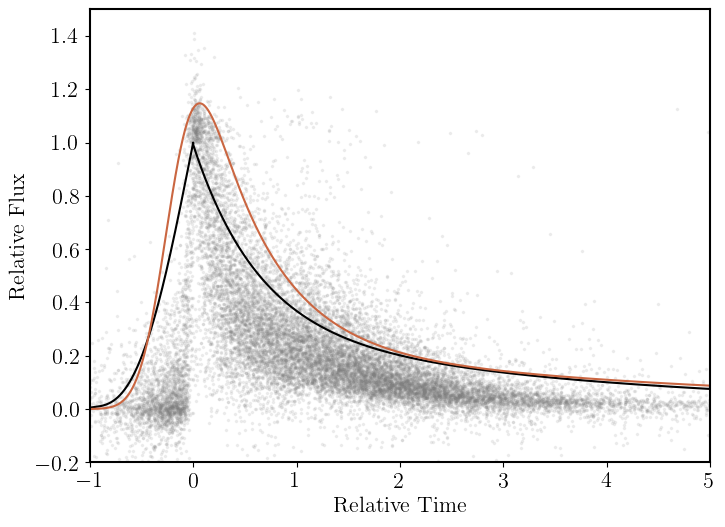

In [38]:
plt.figure(figsize=(8, 6))
font = {'size'   : 16}
plt.rc('font', **font)

plt.plot(time[ns_all],jim_model[ns_all],color='black',label='Davenport (2014) et.al')
#plt.plot(time[ns_all]-2,flare_model(time,0,1,1)[ns_all],label='New model',color='C0')
plt.plot(time[ns_all]-2,flare_model(time,0,1,1.2)[ns_all],label='New model',color='#ca6641')
#plt.plot(time[ns_all],jackman2(time,(0.91780987, 1.72326426, 0.25978216, 0.81791936, 72.63673096, 2.76862114))[ns_all],label='Jims vals',color='orange')
plt.scatter(time[ns_all],flux[ns_all],alpha=0.1,s=10,marker='.',color='grey')
#plt.xlim(-4,5)
plt.ylim(-0.2,1.5)
plt.xlim(-1,5)
#plt.legend(loc='upper right',fontsize=14)
plt.xlabel('Relative Time')
plt.ylabel('Relative Flux')

In [39]:
old_stack=pd.read_csv('stacked_flare_values.csv')
#old_stack
old_time = old_stack['time'].values
os_sort = np.argsort(old_time)
model2014 = aflare1(old_time,0,1,1)
model2020 = flare_model(old_time,-2,1,1.05)

Text(0.5, 1.0, 'V2')

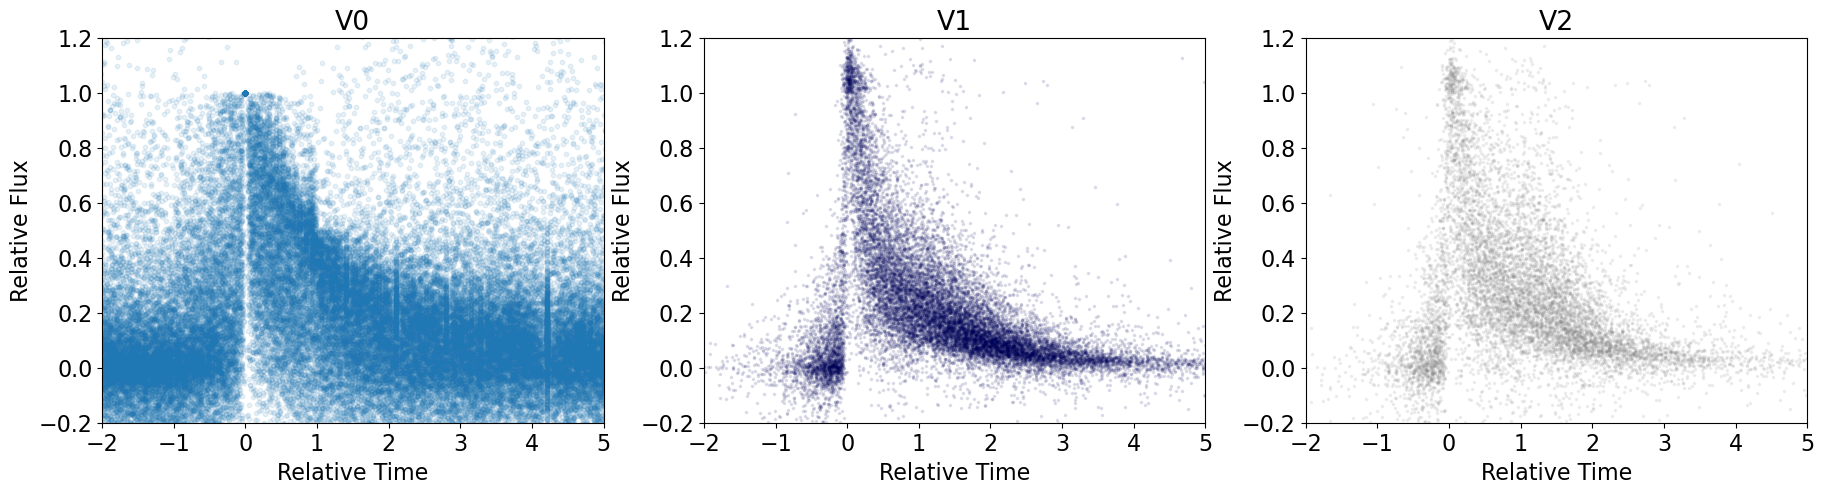

In [292]:
fig, axs = plt.subplots(1,3, figsize=(22, 5), facecolor='w', edgecolor='k')
axs[1].scatter(time[ns_all],flux[ns_all],alpha=.1,s=10,marker='.',color='#00035b',label='V1')
axs[0].scatter(old_time[os_sort],old_stack['flux'][os_sort],color='C0',alpha=0.1,s=10,label='V0')
axs[2].scatter(time_v2[v2_sort],flux_v2[v2_sort],alpha=.1,s=10,marker='.',color='grey',label='V1')
#plt.plot(time[ns_all],aflare1(time,0,1,1)[ns_all],color='black',label='Davenport (2014) et al.')
#plt.plot(time[ns_all]-2,flare_model(time,0,1,1)[ns_all],label='New model',color='C0')
#plt.plot(time[ns_all],flare_model(time,-2,1,1.2)[ns_all],label='New model',color='#ca6641')
axs[0].set_ylim(-0.2,1.2)
axs[0].set_xlim(-2,5)

axs[1].set_ylim(-0.2,1.2)
axs[1].set_xlim(-2,5)

axs[2].set_ylim(-0.2,1.2)
axs[2].set_xlim(-2,5)

axs[0].set_xlabel('Relative Time')
axs[0].set_ylabel('Relative Flux')

axs[1].set_xlabel('Relative Time')
axs[1].set_ylabel('Relative Flux')

axs[2].set_xlabel('Relative Time')
axs[2].set_ylabel('Relative Flux')

axs[1].set_title('V1')
axs[0].set_title('V0')
axs[2].set_title('V2')
#plt.legend(loc='upper right',fontsize=16)
#plt.savefig('flare_sample_comparison.png',bbox_inches='tight')

In [293]:
print(len(old_time))
print(len(time))
print(len(time_v2))

157194
18576
9649


/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in multiply


Text(0, 0.5, 'Relative Flux')

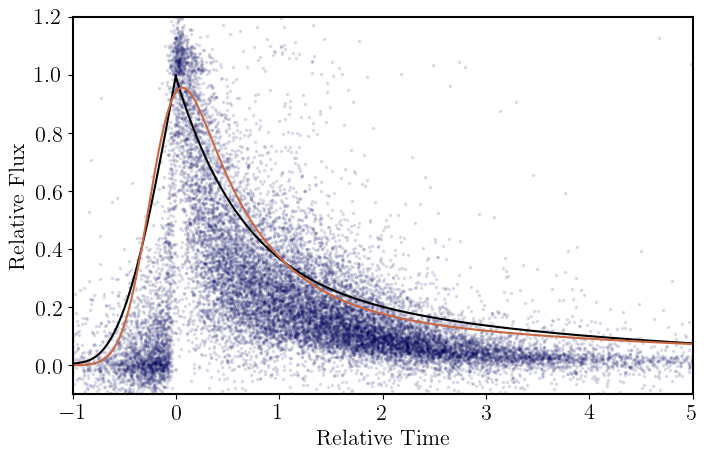

In [41]:
plt.scatter(time[ns_all],flux[ns_all],alpha=.1,s=10,marker='.',color='#00035b')
#plt.scatter(old_time[os_sort],old_stack['flux'][os_sort],color='C0',alpha=0.01,s=12)
plt.plot(time[ns_all],aflare1(time,0,1,1)[ns_all],color='black',label='Davenport (2014) et al.')
#plt.plot(time[ns_all]-2,flare_model(time,0,1,1)[ns_all],label='New model',color='C0')
plt.plot(time[ns_all],flare_model(time,-2,1,1)[ns_all],label='New model',color='#ca6641')
plt.ylim(-0.1,1.2)
plt.xlim(-1,5)
plt.xlabel('Relative Time')
plt.ylabel('Relative Flux')
#plt.legend(loc='upper right',fontsize=16)
#plt.savefig('new_stack_both_models.png',bbox_inches='tight')

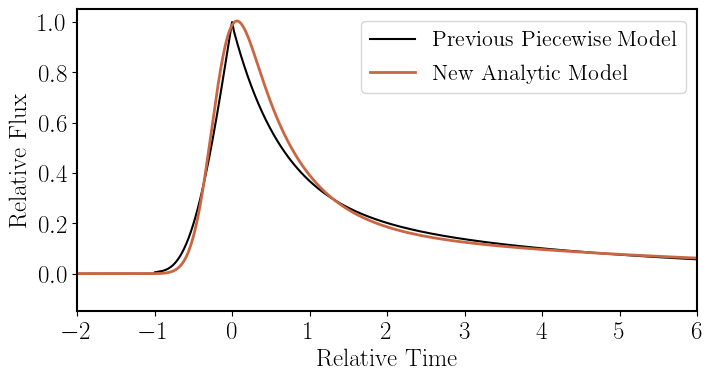

In [42]:
rcParams["font.size"] = 18
#rcParams["figure.figsize"] = [8, 4]
#rcParams["font.family"] = "sans-serif"
#rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
#rcParams["text.usetex"] = True

plt.figure(figsize=[8,4])

#color = "#ff7f0e"

plt.rcParams['axes.linewidth']=1.5


#plt.scatter(old_time[os_sort],old_stack['flux'][os_sort],color='C0',alpha=0.05,s=10)
plt.plot(old_time[os_sort],model2014[os_sort],color='black',label='Previous Piecewise Model',lw=1.5)
plt.plot(old_time[os_sort],model2020[os_sort],color='#ca6641',label='New Analytic Model',lw=2)
plt.xlim(-2,6)
plt.ylim(-0.15,1.05)
plt.xlabel('Relative Time')
plt.ylabel('Relative Flux')
#plt.savefig('/Users/lupitatovar/TESS_Cycle4/figures/flare_models.png',bbox_inches='tight')
plt.legend(loc = 'upper right',fontsize=16)#bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#plt.savefig('/Users/lupitatovar/TESS_Cycle4/figures/flare_models.png',bbox_inches='tight')

### Fitting each flare

In [43]:
from scipy.optimize import least_squares,curve_fit, minimize

In [44]:
#fitting using Flare model based on the Jackman model (double exponential)

#taking care of nan_arrays

t_nan_array = np.isnan(time[ns_all])
t_not_nan_array = ~ t_nan_array
no_nan_time = time[t_not_nan_array]

no_infs = np.isfinite(no_nan_time)
i=0

# arrays to feed into curvefit
x_to_fit = no_nan_time[no_infs]

y_to_fit = flux[t_not_nan_array][no_infs]


#defining the error array to feed into curvefit
error = np.sqrt( (flux_err[t_not_nan_array][no_infs])**2 + (gp_err[t_not_nan_array][no_infs])**2 )

#flare1 = flare_model(no_nan_time,0,1,1.2)
#no_nans = (flare1[~np.isnan(flare1)])

#jim_flare = aflare1(no_nan_time,0,1,1)
#jackman_model = jackman(x_all_ylim,0.02675881, 6.62072363, 6.51545681, 0.96707504, 0.92314355, -6.28890682)[ysorter]
#init_vals = [2.93019203, 1.78279154, 0.3113989, 0.21181818, 1.63976688, 0.13602386]  

#i=1

#init_vals from Jim's model
# _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
#_fd = [0.689008, -1.60053, 0.302963, -0.278318]
#-2,1,1.2
init_vals= [-2,1,1.2]

best_vals, covar = curve_fit(flare_model, x_to_fit,y_to_fit, p0=init_vals,sigma=error,maxfev=100000)
print('best_vals: {}'.format(best_vals))

best_vals: [-0.61577631  0.33446854  1.05363021]


(-2.0, 5.0)

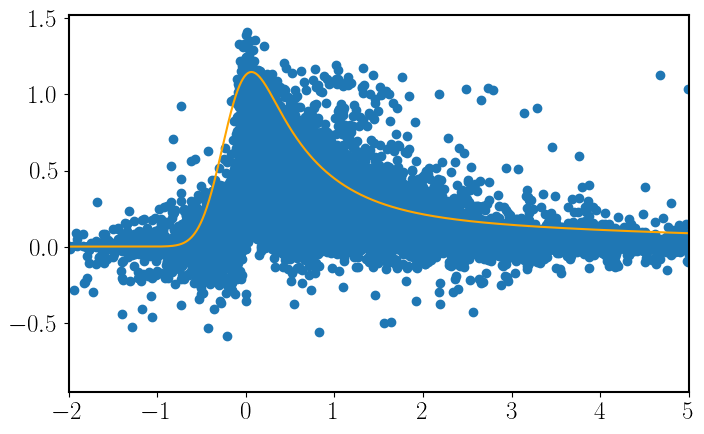

In [45]:
fit_sort = np.argsort(x_to_fit)

plt.scatter(time[ns_all],flux[ns_all])
plt.plot(x_to_fit[fit_sort], flare_model(x_to_fit[fit_sort], *init_vals),color='orange',label='init vals')
plt.xlim(-2,5)

In [46]:
print(x_to_fit[fit_sort])
print(y_to_fit[fit_sort])

[ -7.35592882  -7.33758404  -7.04356695 ... 775.49453478 805.31585567
 835.14155521]
[ 0.00201457  0.0366823   0.00314082 ... -0.08008215 -0.17696756
 -0.25643146]


(-0.1, 1.5)

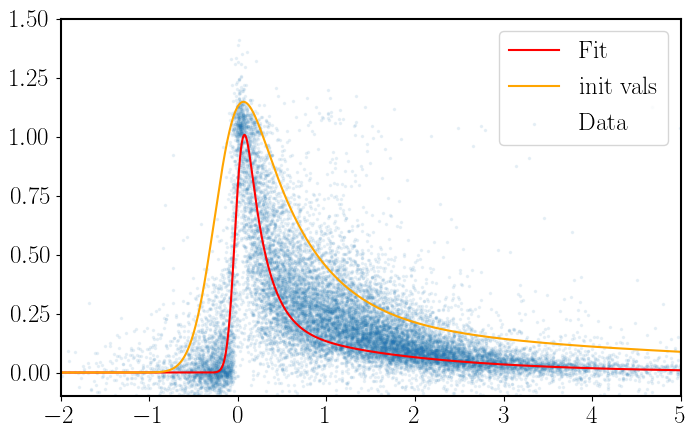

In [47]:
#plt.figure(figsize=(6, 4))
#plt.scatter(time,flux,alpha=.05,s=10,marker='.',label='Data')

plt.scatter(x_to_fit[fit_sort],y_to_fit[fit_sort],alpha=.08,s=10,marker='.',label='Data')
plt.plot(x_to_fit[fit_sort], flare_model(x_to_fit[fit_sort],*best_vals),label='Fit',color='red')

plt.plot(x_to_fit[fit_sort], flare_model(x_to_fit[fit_sort], *init_vals),color='orange',label='init vals')

plt.legend(loc='best')
plt.xlim(-2,5)
plt.ylim(-0.1,1.5)
#plt.show()

In [48]:
print('best_vals: {}'.format(best_vals))
print('covar:{}'.format(covar))

best_vals: [-0.61577631  0.33446854  1.05363021]
covar:[[ 2.47009964e-05 -1.26167946e-05  1.86906316e-05]
 [-1.26167946e-05  6.61100604e-06 -9.78952753e-06]
 [ 1.86906316e-05 -9.78952753e-06  2.94030951e-05]]


### Fitting each flare within the cross-match table
The resulting fits for each flare (i.e the 'best_vals') will be used as input data to stack the flares using the old stacking procedure. From there the new stack of flares will be fit using mcmc, and the resulting chi^2 of stack will be our numerical comparison to evaluate which stacking procedure is more efficient

In [49]:
error1 = np.sqrt( (((df['df_flux_err'].values)**2)) + (((df['std'].values)**2)))

#coeffs = []
tpeaks = [] 
fwhms = [] 
amps = []


tpeaks_err = []
fwhms_err = []
amps_err = []
#t, tpeak, fwhm, ampl
for i in range (0,len(cross_match)):

    #taking care of nan_arrays

    t_nan_array = np.isnan(time[ns_all])
    t_not_nan_array = ~ t_nan_array
    no_nan_time = time[t_not_nan_array]

    no_infs = np.isfinite(no_nan_time)

    #Defining times of each flare event
    i_temp = np.where((df['time'].values <= cross_match['t_stop'].values[i]) & 
                    (df['time'].values >= cross_match['t_start'].values[i]))[0]
    
    peak_flujo = cross_match['t_stop'].values-cross_match['t_start'].values
    # arrays to feed into curvefit
    #x_to_fit = no_nan_time[no_infs]
    #y_to_fit = flux[t_not_nan_array][no_infs]
    
    x_fit = df['time'].values[i_temp]
    y_fit = detrended[i_temp]


    #defining the error array to feed into curvefit
    #error1 = np.sqrt( (((df['df_flux_err'].values)**2)) + (((df['std'].values)**2)))
    

    #print(error1)
    init_vals= [cross_match['t_peak'].values[i],cross_match['flux peak'].values[i]/2 ,peak_flujo[i]]

    best_vals, covar = curve_fit(flare_model,x_fit,y_fit, p0=init_vals, maxfev=10000, sigma = error1[i_temp])
    
    #absolute_sigma = True
    #print('best_vals: {}'.format(best_vals))
    
    err = np.sqrt(np.diag(covar))
    ############# Saving Output Arrays ################
    tpeaks = np.append(tpeaks,best_vals[0])
    fwhms = np.append(fwhms,best_vals[1])
    amps = np.append(amps,best_vals[2])
    
    tpeaks_err = np.append(tpeaks_err,err[0])
    fwhms_err = np.append(fwhms_err,err[1])
    amps_err = np.append(amps_err,err[2])


/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in exp
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in multiply
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in exp


Re-running with vetted flare list round 2

In [295]:
#coeffs = []
tpeaks2 = [] 
fwhms2 = [] 
amps2 = []

tpeaks_err2 = []
fwhms_err2 = []
amps_err2 = []
#t, tpeak, fwhm, ampl
for i in range (0,len(cross_match2)):

    #taking care of nan_arrays

    t_nan_array2 = np.isnan(time_v2[v2_sort])
    t_not_nan_array2 = ~ t_nan_array2
    no_nan_time2 = time_v2[t_not_nan_array2]

    no_infs2 = np.isfinite(no_nan_time2)

    #Defining times of each flare event
    i_temp2 = np.where((df['time'].values <= cross_match2['t_stop'].values[i]) & 
                    (df['time'].values >= cross_match2['t_start'].values[i]))[0]
    
    peak_flujo2 = cross_match2['t_stop'].values-cross_match2['t_start'].values
    # arrays to feed into curvefit
    #x_to_fit = no_nan_time[no_infs]
    #y_to_fit = flux[t_not_nan_array][no_infs]
    
    x_fit2 = df['time'].values[i_temp2]
    y_fit2 = detrended[i_temp2]


    #defining the error array to feed into curvefit
    #error1 = np.sqrt( (((df['df_flux_err'].values)**2)) + (((df['std'].values)**2)))
    

    #print(error1)
    init_vals2= [cross_match2['t_peak'].values[i],cross_match2['flux peak'].values[i]/2 ,peak_flujo2[i]]

    best_vals2, covar2 = curve_fit(flare_model,x_fit2,y_fit2, p0=init_vals2, maxfev=10000, sigma = error1[i_temp2])
    
    #absolute_sigma = True
    #print('best_vals: {}'.format(best_vals))
    
    err2 = np.sqrt(np.diag(covar2))
    ############# Saving Output Arrays ################
    tpeaks2 = np.append(tpeaks2,best_vals2[0])
    fwhms2 = np.append(fwhms2,best_vals2[1])
    amps2 = np.append(amps2,best_vals2[2])
    
    tpeaks_err2 = np.append(tpeaks_err2,err2[0])
    fwhms_err2 = np.append(fwhms_err2,err2[1])
    amps_err2 = np.append(amps_err2,err2[2])


/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in sqrt


In [296]:
print(len(covar2))
print(len(err2))
print(len(tpeaks_err2))
print(len(fwhms_err2))
print(len(amps_err2))

3
3
303
303
303


In [331]:
#print(df['df_flux_err'].values)
#print(df['std'].values)

In [332]:
#print(y_fit)

In [297]:
#print(covar)
print(init_vals2)

[1119.8000488, 0.006688550000000001, 0.017700200000035693]


In [334]:
#print(len(df['time'].values))
#print(len(detrended))
#print(len(error1))

In [335]:
#print(tpeaks)
#print(fwhms)
#print(amps)
#print(covar)

In [342]:
#print(init_vals[0])

1272.4312744000001


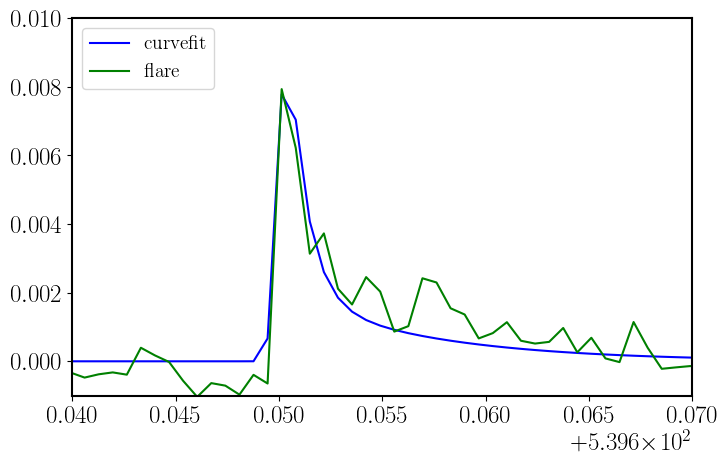

In [51]:
plt.plot(df['time'],flare_model(df['time'],tpeaks[0],fwhms[0],amps[0]),color='b',label='curvefit')
#plt.plot(df['time'],flare_model(df['time'],*init_vals),color='orange',label='init guess')
plt.plot(df['time'],detrended,color='green',label='flare')
plt.xlim(539.64,539.67)
plt.ylim(-0.001,0.01)
plt.legend(loc='upper left',fontsize='14')

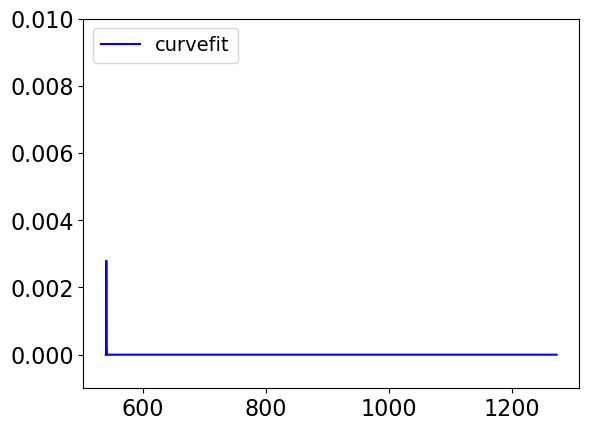

In [309]:
plt.plot(df['time'],flare_model(df['time'],tpeaks2[1],fwhms2[1],amps2[1]),color='b',label='curvefit')
#plt.plot(df['time'],flare_model(df['time'],init_vals2[0]),color='orange',label='init guess')
#plt.plot(df['time'],detrended,color='green',label='flare')
#plt.xlim(539.64,539.67)
plt.ylim(-0.001,0.01)
plt.legend(loc='upper left',fontsize='14')

In [344]:
#plt.plot(df['time'],flare_model(df['time'].values,cross_match['t_peak'].values[1],cross_match['flux peak'].values[1] ,cross_match['flux peak'].values[1]),color='blue')
#plt.plot(df['time'],flare_model(df['time'].values,cross_match['t_peak'].values[1],(cross_match['flux peak'].values[1])/2 ,(peak_flujo[1])),color='orange')
#plt.plot(df['time'],detrended,color='green',label='flare')

#plt.xlim(539.86,539.9)
#plt.ylim(-.001,.02)

In [345]:
#lightcurve errors
#print(df['df_flux_err'].values)
#print(df['std'].values)

In [346]:
#cross_match

In [347]:
#plt.plot(df['time'],detrended)

In [300]:
#plt.errorbar(x_to_fit[i_temp],y_to_fit[i_temp],yerr=error1[i_temp])

In [ ]:
#len(cross_match['t_stop'].values)
#print(len(time) )                         #relative time
#print(len(df['time'].values))             #light curve times
#print (len(cross_match['t_stop'].values)) #stop time values of flares

Stacking the flare fits using the old stacking procedure

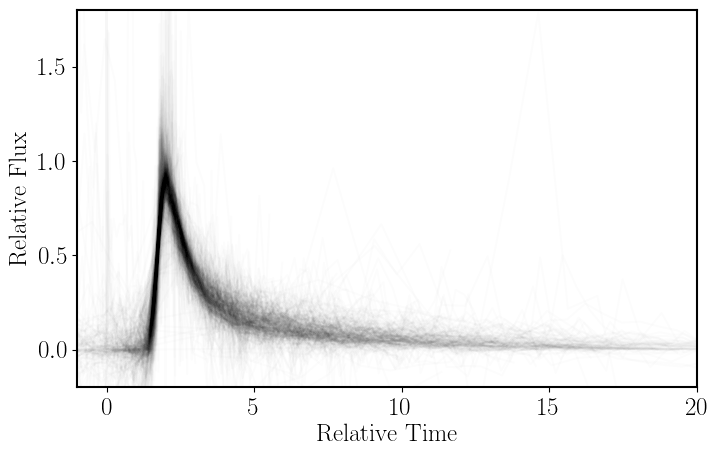

In [56]:
time_stack_fits=np.array([])
flux_stack_fits=np.array([])
stack_y_err = np.array([])
stack_gp_st_dev = np.array([])
xlim1=-1
xlim2=20
ylim1= -0.2
ylim2= 1.8

#plt.figure( figsize=(15, 5), facecolor='w', edgecolor='k')
for i in range(0,len(cross_match)):
 
    
    #coeffs array already has these values: tpeak(time_max), fwhm(t_half), ampl(peak)
    # defining the variable to plot
    i_temp = np.where((df['time'].values <= cross_match['t_stop'].values[i]) & 
                    (df['time'].values >= cross_match['t_start'].values[i]))[0]
    
    temp_x_stack = (df['time'].values[i_temp] - tpeaks[i])/(fwhms[i])
    temp_y_stack = ((detrended[i_temp])/(amps[i]))
    plt.plot(temp_x_stack,temp_y_stack,color='black',alpha=0.01)


    #Time Arrays
    nxs = np.where((temp_x_stack <= xlim2) & (temp_x_stack>=xlim1)& (temp_y_stack <= ylim2) & (temp_y_stack>=ylim1))[0]
    time_stack_fits = np.append(time_stack_fits,temp_x_stack[nxs])
        
    #Flux Arrays
    flux_stack_fits = np.append(flux_stack_fits,temp_y_stack[nxs])
        
    #Flux Errors
    new_flux_err = df['df_flux_err'].values/tpeaks[i] 
    stack_y_err = np.append(stack_y_err,new_flux_err[nxs])
        
    #GP Standard Deviation
    new_st_dev = df['std'].values/tpeaks[i]
    stack_gp_st_dev = np.append(stack_gp_st_dev,new_st_dev[nxs])
                  
   
    
    ########## PLOTTING ################
    #plt.plot(temp_x_stack,temp_y_stack,color='k',alpha=0.01)

    #the plot below is in cumulative distribution space
    #plt.plot(temp_x_stack,np.cumsum(temp_y_stack)/np.sum(temp_y_stack),color='k')

   

    #Setting Titles
    #axs[0].set_title('Stacked Flares')
    #axs[1].set_title('Cumulative Distribution')
    

    #Axes labels
    plt.xlabel("Relative Time")
    plt.ylabel("Relative Flux")    
    #axs[1].set_ylabel("Cummulative Flux")
    #axs[1].set_xlabel("Relative Time")

    #Axes limits
    plt.xlim(-1,20)
    plt.ylim(-0.2,1.8)
    
    
#plt.plot(x_new,aflare1(x_new,0,1,1),color='red',label='Jims Model')        
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)    
    

#plt.savefig('')


Stacking using the new vetted flares

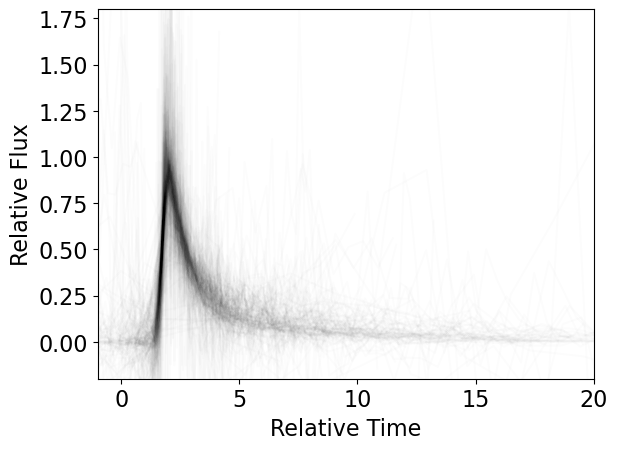

In [310]:
time_stack_fits2=np.array([])
flux_stack_fits2=np.array([])
stack_y_err2 = np.array([])
stack_gp_st_dev2 = np.array([])
xlim1=-1
xlim2=20
ylim1= -0.2
ylim2= 1.8

#plt.figure( figsize=(15, 5), facecolor='w', edgecolor='k')
for i in range(0,len(cross_match2)):
 
    
    #coeffs array already has these values: tpeak(time_max), fwhm(t_half), ampl(peak)
    # defining the variable to plot
    i_temp2 = np.where((df['time'].values <= cross_match2['t_stop'].values[i]) & 
                    (df['time'].values >= cross_match2['t_start'].values[i]))[0]
    
    temp_x_stack2 = (df['time'].values[i_temp2] - tpeaks2[i])/(fwhms2[i])
    temp_y_stack2 = ((detrended[i_temp2])/(amps2[i]))
    plt.plot(temp_x_stack2,temp_y_stack2,color='black',alpha=0.01)


    #Time Arrays
    nxs2 = np.where((temp_x_stack2 <= xlim2) & (temp_x_stack2>=xlim1)& (temp_y_stack2 <= ylim2) & (temp_y_stack2>=ylim1))[0]
    time_stack_fits2 = np.append(time_stack_fits2,temp_x_stack2[nxs2])
        
    #Flux Arrays
    flux_stack_fits2 = np.append(flux_stack_fits2,temp_y_stack2[nxs2])
        
    #Flux Errors
    new_flux_err2 = df['df_flux_err'].values/tpeaks2[i] 
    stack_y_err2 = np.append(stack_y_err2,new_flux_err2[nxs2])
        
    #GP Standard Deviation
    new_st_dev2 = df['std'].values/tpeaks2[i]
    stack_gp_st_dev2 = np.append(stack_gp_st_dev2,new_st_dev2[nxs2])
                  
   
    
    ########## PLOTTING ################
    #plt.plot(temp_x_stack,temp_y_stack,color='k',alpha=0.01)

    #the plot below is in cumulative distribution space
    #plt.plot(temp_x_stack,np.cumsum(temp_y_stack)/np.sum(temp_y_stack),color='k')

   

    #Setting Titles
    #axs[0].set_title('Stacked Flares')
    #axs[1].set_title('Cumulative Distribution')
    

    #Axes labels
    plt.xlabel("Relative Time")
    plt.ylabel("Relative Flux")    
    #axs[1].set_ylabel("Cummulative Flux")
    #axs[1].set_xlabel("Relative Time")

    #Axes limits
    plt.xlim(-1,20)
    plt.ylim(-0.2,1.8)
    
    
#plt.plot(x_new,aflare1(x_new,0,1,1),color='red',label='Jims Model')        
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)    
    

#plt.savefig('')


In [311]:
#saving the arrays to a file with V2 o vetted flares
#dict_i = {'time':time_stack_fits2,'flux':flux_stack_fits2 , 'flux_err':stack_y_err2 , 'gp_st_dev':stack_gp_st_dev2 } 
#stacked_fit_flares2 = pd.DataFrame(data=dict_i) 
#stacked_fit_flares2.to_csv(r'stacked_fit_flare_vals2.csv',header=True,index=True)

In [312]:
fit_flare_vals2=pd.read_csv('stacked_fit_flare_vals2.csv')

In [57]:
#saving the arrays to a file
#dict_i = {'time':time_stack_fits,'flux':flux_stack_fits , 'flux_err':stack_y_err , 'gp_st_dev':stack_gp_st_dev } 
#stacked_fit_flares = pd.DataFrame(data=dict_i) 
#stacked_fit_flares.to_csv(r'stacked_fit_flare_vals.csv',header=True,index=True)

In [58]:
fit_flare_vals=pd.read_csv('stacked_fit_flare_vals.csv')

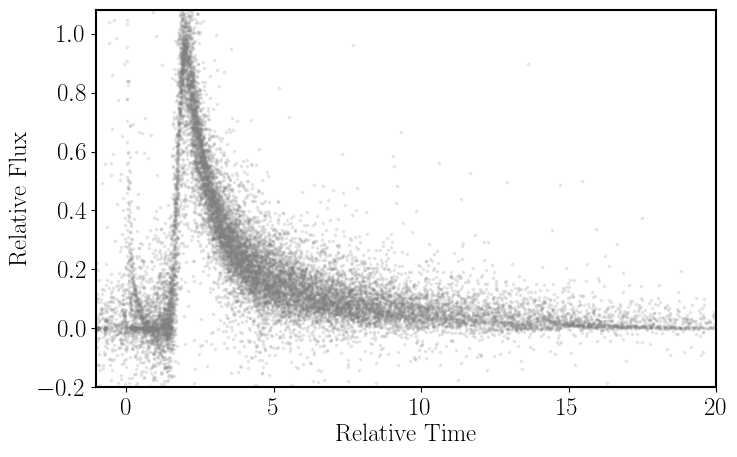

In [60]:
fit_time = fit_flare_vals['time'].values
fit_flux = fit_flare_vals['flux'].values
fit_flux_err = fit_flare_vals['flux_err'].values
fit_gp_err = fit_flare_vals['gp_st_dev'].values

fit_both_errors = np.sqrt( (fit_flux_err)**2 + (fit_gp_err)**2 )

fit_sort = np.argsort(fit_time)
plt.scatter(fit_time[fit_sort],fit_flux[fit_sort],alpha=.15,s=10,marker='.',color='grey')
plt.ylim(-0.2,1.08)
plt.xlim(-1,20)
plt.xlabel("Relative Time")
plt.ylabel("Relative Flux")
#plt.savefig('/Users/lupitatovar/flares/figures/fit_stacked_flares.png',bbox_inches='tight')

Text(0, 0.5, 'Relative Flux')

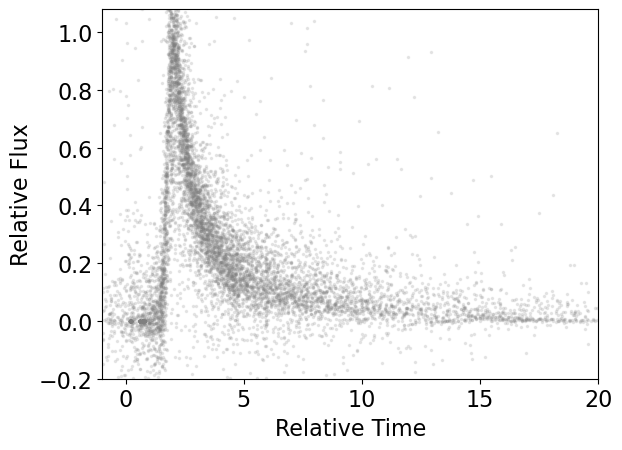

In [313]:
fit_time2 = fit_flare_vals2['time'].values
fit_flux2 = fit_flare_vals2['flux'].values
fit_flux_err2 = fit_flare_vals2['flux_err'].values
fit_gp_err2 = fit_flare_vals2['gp_st_dev'].values

fit_both_errors2 = np.sqrt( (fit_flux_err2)**2 + (fit_gp_err2)**2 )

fit_sort2 = np.argsort(fit_time2)
plt.scatter(fit_time2[fit_sort2],fit_flux2[fit_sort2],alpha=.15,s=10,marker='.',color='grey')
plt.ylim(-0.2,1.08)
plt.xlim(-1,20)
plt.xlabel("Relative Time")
plt.ylabel("Relative Flux")

Text(0, 0.5, 'Relative Flux')

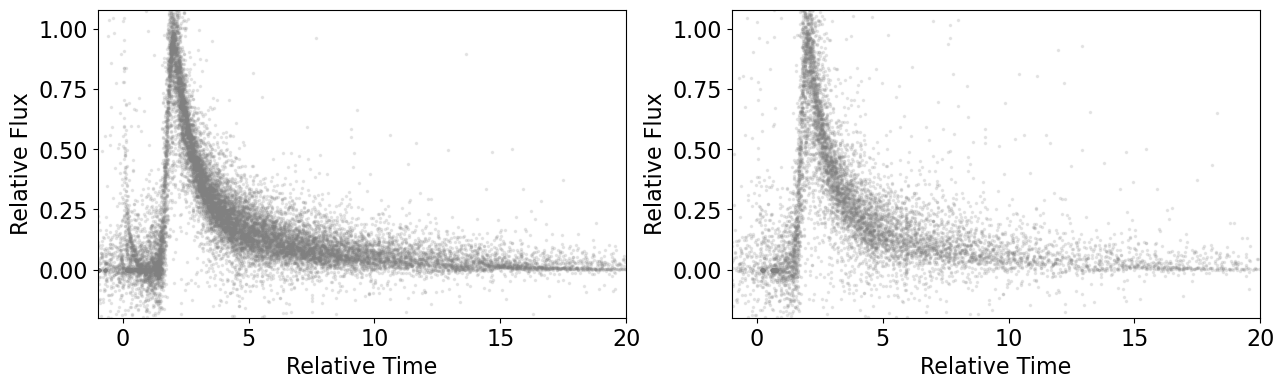

In [321]:
fig, axs = plt.subplots(1,2, figsize=(15, 4), facecolor='w', edgecolor='k')
axs[0].scatter(fit_time[fit_sort],fit_flux[fit_sort],alpha=.15,s=10,marker='.',color='grey')
axs[1].scatter(fit_time2[fit_sort2],fit_flux2[fit_sort2],alpha=.15,s=10,marker='.',color='grey')


axs[0].set_ylim(-0.2,1.08)
axs[0].set_xlim(-1,20)
axs[0].set_xlabel("Relative Time")
axs[0].set_ylabel("Relative Flux")


axs[1].set_ylim(-0.2,1.08)
axs[1].set_xlim(-1,20)
axs[1].set_xlabel("Relative Time")
axs[1].set_ylabel("Relative Flux")

In [314]:
len(cross_match)
len(tpeaks2) 

#fwhms
#amps 

303

In [315]:
cross_match2

index of flare start in "gj1243_master_slc.dat"  \
0                                              594.0   
1                                             1262.0   
2                                             2438.0   
3                                             2475.0   
4                                             2565.0   
..                                               ...   
298                                         233014.0   
299                                         233574.0   
300                                         234145.0   
301                                         235469.0   
302                                         235919.0   

     index of flare stop in "gj1243_master_slc.dat"      t_start       t_stop  \
0                                             614.0   539.865967   539.880249   
1                                            1288.0   540.326416   540.344788   
2                                            2459.0   541.142456   541.156738   
3                                            2517.0   541.167664   541.196899   
4                                            2587.0   541.229614   541.245300   
..                                              ...          ...          ...   
298                                        233039.0  1115.522827  1115.540527   
299                                        233593.0  1115.936890  1115.951172   
300                                        234165.0  1116.423218  1116.437500   
301                                        235512.0  1119.486084  1119.516724   
302                                        235944.0  1119.797363  1119.815063   

          t_peak    t_rise   t_decay  flux peak         ED  Duration of rise  \
0     539.870056  0.004089  0.010193   0.004795   0.978497          0.187819   
1     540.328491  0.002075  0.016296   0.002447   1.303812          0.137945   
2     541.144470  0.002014  0.012268   0.006591   2.378301          0.567651   
3     541.173096  0.005432  0.023804   0.010578   4.931096          1.413226   
4     541.232361  0.002747  0.012940   0.005510   1.937838          0.650844   
..           ...       ...       ...        ...        ...               ...   
298  1115.525513  0.002685  0.015015   0.015606   4.351948          0.896782   
299  1115.938232  0.001343  0.012940   0.024651   5.440639          1.520191   
300  1116.424561  0.001343  0.012940   0.017358   4.025050          1.019865   
301  1119.489502  0.003418  0.027222   0.147704  38.017441          9.287478   
302  1119.800049  0.002685  0.015015   0.013377   4.464341          1.349631   

     ...  # of people that identified flare event exists  \
0    ...                                             8.0   
1    ...                                             5.0   
2    ...                                             8.0   
3    ...                                             8.0   
4    ...                                             8.0   
..   ...                                             ...   
298  ...                                             6.0   
299  ...                                             6.0   
300  ...                                             6.0   
301  ...                                             6.0   
302  ...                                             6.0   

     # of people that analyzed this month  \
0                                     8.0   
1                                     8.0   
2                                     8.0   
3                                     8.0   
4                                     8.0   
..                                    ...   
298                                   6.0   
299                                   6.0   
300                                   6.0   
301                                   6.0   
302                                   6.0   

     # of flare template components fit to event  Flare_Duration  Index  \
0                                            1.0       20.566

### Stacked Flare Diagnostics

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


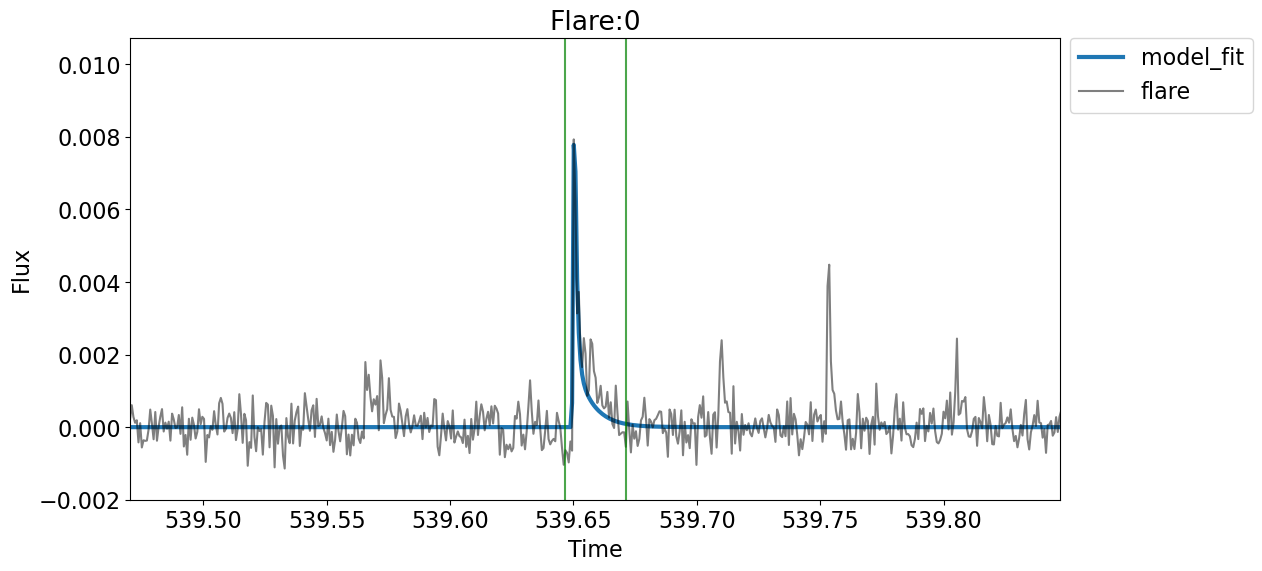

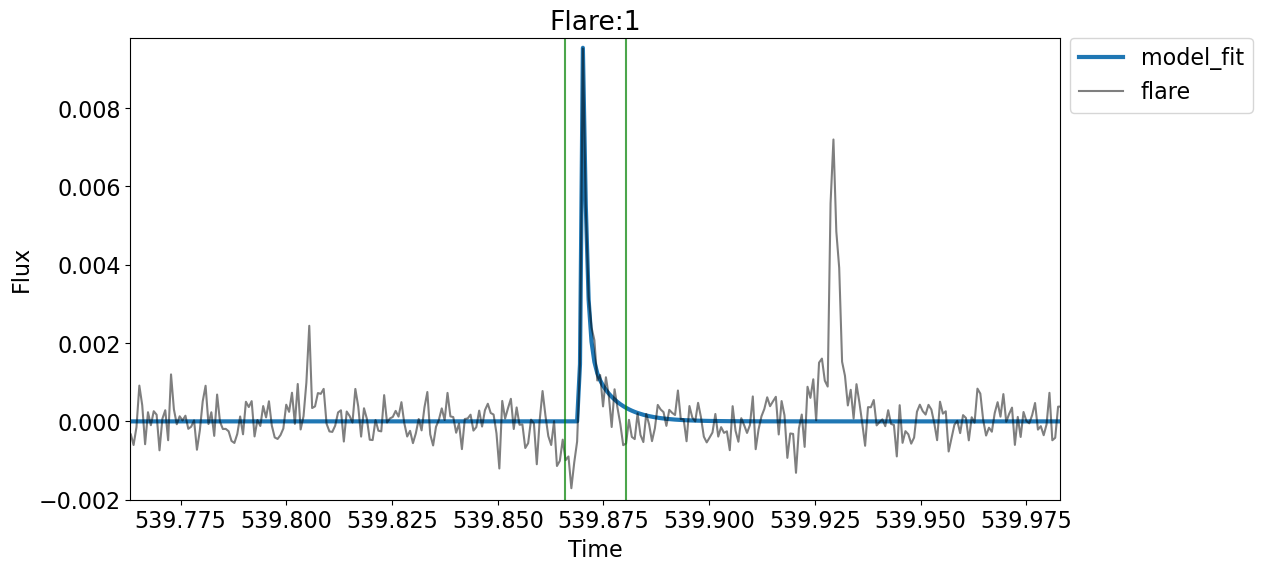

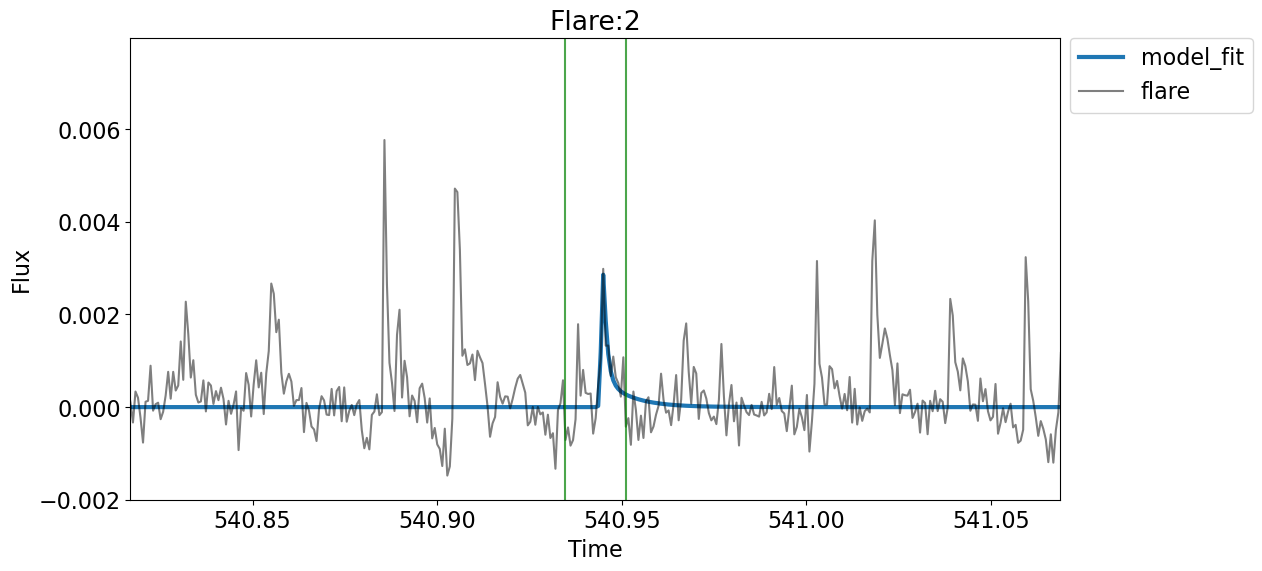

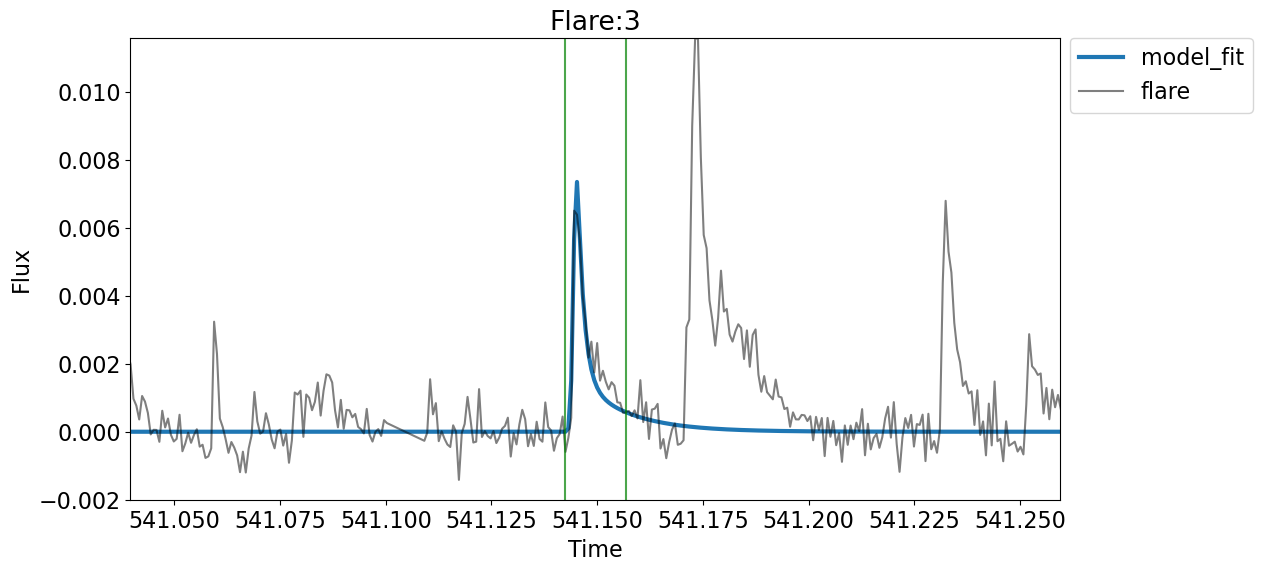

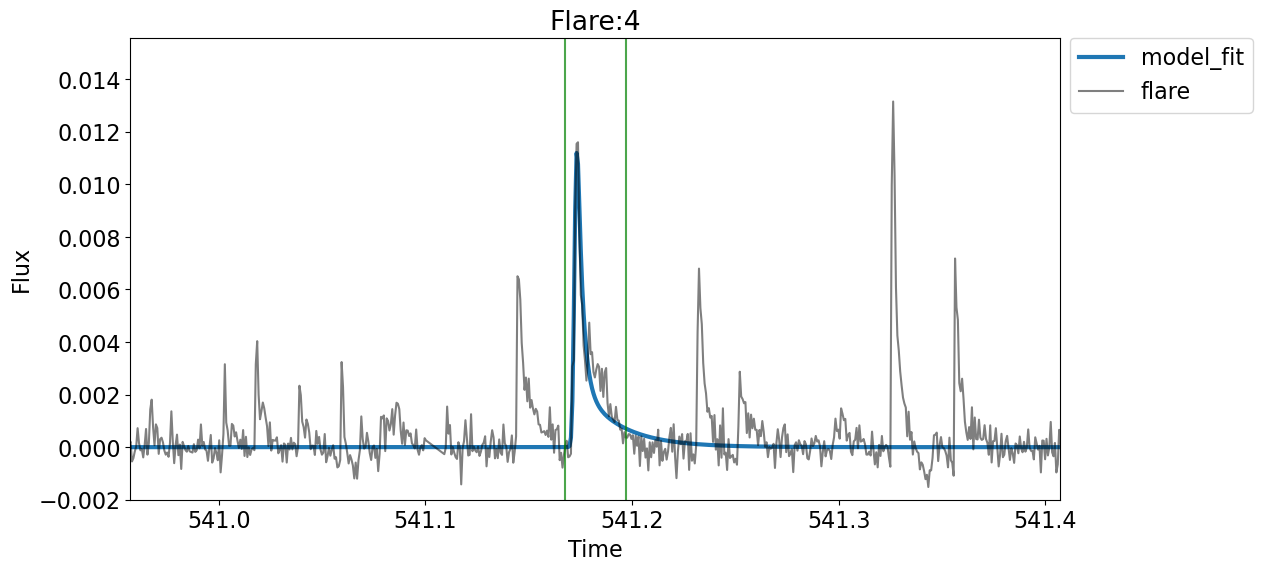

In [211]:
for i in range(0,5):#len(cross_match)):
    plt.figure(figsize=[12,6])
    #flux_fwhm = np.where(yinterp > half_peaks[i])[0] 
    
    #plt.scatter(tpeaks[i],amps[i],color='red',label='peak',s=50)
    i_temp = np.where((df['time'].values <= cross_match['t_stop'].values[i]) & 
                    (df['time'].values >= cross_match['t_start'].values[i]))[0]
    
    temp_x_stack = (df['time'].values[i_temp] - tpeaks[i])/(fwhms[i])
    temp_y_stack = ((detrended[i_temp])/(amps[i]))
    #plt.plot(temp_x_stack[i],temp_y_stack[i],color='black')
    #plt.plot(xvals,yinterp,color='black',alpha=0.8,label='interp_data')
    #plt.plot(np.where(xvals,np.where((yinterp > half_peaks[i]))[0],color='black',alpha=0.8,label='interp_data')
    #plt.scatter(xvals[flux_fwhm],yinterp[flux_fwhm], color='red', s=20,label='flux>fwhm',alpha=0.5)

    plt.plot(df['time'],flare_model(df['time'],tpeaks[i],fwhms[i],amps[i]),color='C0',label='model_fit',lw=3)

    plt.plot(df['time'],detrended,color='black',label='flare',alpha=0.5)

    #plt.axhline(y=half_peaks[i], color='green', linestyle='-',label='t_half',alpha=0.7)
    plt.axvline(x=cross_match['t_start'].values[i], color='green', linestyle='-',alpha=0.7)
    plt.axvline(x=cross_match['t_stop'].values[i], color='green', linestyle='-',alpha=0.7)
    

    plt.ylim(-.002,cross_match['flux peak'].values[i]+.005)
    #plt.xlim(timed_classical['t_start'].values[i]-.1,timed_classical['t_stop'].values[i]+.1)
    plt.xlim(cross_match['t_start'].values[i]-.005*cross_match['Flare_Duration'].values[i],cross_match['t_stop'].values[i]+.005*cross_match['Flare_Duration'].values[i])
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    plt.title('Flare:'+ str(i))
    plt.xlabel('Time')
    plt.ylabel('Flux')
    #plt.savefig('/Users/lupitatovar/local_flares/notebooks/flare_diagnostics2/'+'flare'+str(i)+'.png',bbox_inches='tight')
    #plt.close()

In [57]:
def flare_model(t,tpeak, fwhm, ampl):

    t_new = (t-tpeak)/fwhm


    #Values were fit & calculated using MCMC 256 walkers and 10000 steps

    A,B,C,D1,D2,f1 = [2.93019203, 1.78279154, 0.3113989, 0.21181818, 1.63976688, 0.13602386]
    z1 = ((2*B + (C**2 *D1))/(2*C))
    z2 = ((2*B + C**2 *D2)/(2*C))
    f2 = 1-f1
    flare = (1/2) * np.sqrt(np.pi) * A * C * ((f1 * np.exp((D1*(B-t_new)) + ((C**2 * D1**2)/4))*(special.erf(z1) - special.erf(z1 - (t_new/C))))
                                             + (f2 * np.exp((D2*(B-t_new)) + ((C**2 * D2**2)/4))*(special.erf(z2) - special.erf(z2 - (t_new/C)))))
    return flare * ampl

### Emcee Fit

In [61]:
import emcee
from IPython.display import display, Math
import corner

In [322]:
A_i,B_i,C_i,D1_i,D2_i,f1_i = [3.40885267,  3.74774459, -0.21710296,  0.16109176,  1.35048373,  0.18575378]
#2.93019203, 1.78279154, 0.3113989, 0.21181818, 1.63976688, 0.13602386 numbers from model V0 run
#3.40885267  3.74774459 -0.21710296  0.16109176  1.35048373  0.18575378

def jackman2(t,theta2):
    A,B,C,D1,D2,f1=theta2
    z1 = ((2*B + (C**2 *D1))/(2*C))
    z2 = ((2*B + C**2 *D2)/(2*C))
    f2 = 1-f1
    double_exp = (1/2) * np.sqrt(np.pi) * A * C * ((f1 * np.exp((D1*(B-t)) + ((C**2 * D1**2)/4))*(special.erf(z1) - special.erf(z1 - (t/C)))) 
                                             + (f2 * np.exp((D2*(B-t)) + ((C**2 * D2**2)/4))*(special.erf(z2) - special.erf(z2 - (t/C)))))
    return double_exp


def lnlike2(theta2, time, flux, both_errors):
    debug = True
    A,B,C,D1,D2,f1 = theta2
    jackman_model = jackman2(time,theta2)
    erf_bound = 0.5*(special.erf((time-0.2)*100) + 1)
    model = jackman_model*erf_bound
    # the dreaded negative-number cliff!
    #if (np.nanmin(model) >= 0) and ((jackman2(np.array([-1000.]),theta2)* (0.5*(special.erf((-1000-0.2)*100) + 1))) >= 0):
    if (np.nanmin(model) < 0):    
        if degug:
            print('DEBUG: model>0 error')
        return -np.inf
    
    if (jackman2(np.array([-1000.]),theta2)* (0.5*(special.erf((-1000-0.2)*100) + 1))) < 0:
        if degug:
            print('DEBUG: -1000 error')    
        return -np.inf
        
    lnlike2 = -0.5*(np.sum(((flux-model)/both_errors)**2))
        #return lnlike2
    return lnlike2

def lnprior2(theta2):
    A,B,C,D1,D2,f1 = theta2
    debug = False
    if (D1 > 0.) and (0. <= f1 <= 1): #D1<0 | f1>1 #switch to and
        if debug:
            print('DEBUG:boundary')
        return 0.0
    #if not np.sum(np.isfinite(theta2)):
        #return -np.inf
    return -np.inf


def lnprob2(theta2, time, flux, both_errors):
    lp2 = lnprior2(theta2)
    debug = False
    try:
        # put the model<0 check in lnlike2!
        ll2 = lnlike2(theta2, time, flux, both_errors)
        output = lp2 + ll2
        if np.any(np.isnan(output)):
            return -np.inf
        return output
    except:
        if debug:
            print ('Debug: ambiguous fail')
        return -np.inf

In [170]:
print((jackman2(-1000,(A_i,B_i,C_i,D1_i,D2_i,f1_i))* (0.5*(special.erf((-1000-0.2)*100) + 1))) >= 0)
print(np.nanmin(jackman2(fit_time,(A_i,B_i,C_i,D1_i,D2_i,f1_i))* (0.5*(special.erf((fit_time-0.2)*100) + 1))))

False
-0.0


/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [323]:
print(np.nanmin(jackman2(fit_time2,(A_i,B_i,C_i,D1_i,D2_i,f1_i))[fit_sort2]) * (0.5*(special.erf((fit_time2-0.2)*100) + 1)))
print(np.nanmin(fit_time2))

[-0. -0. -0. ... -0. -0. -0.]
-0.9788901100634352


In [324]:
#jackman model with best mcmc vals from previous run
print(jackman2(fit_time2,(A_i,B_i,C_i,D1_i,D2_i,f1_i))[fit_sort2])

#jackman model with previous mcmc output vals (these vals produced the - dropoff feature in model)
#print(jackman2(time,(3.00903719, 0.76964953, 0.27737505, 1.40090881, 0.18419468, 0.8782854))[ns_all])

print(lnlike2((A_i,B_i,C_i,D1_i,D2_i,f1_i),fit_time2,fit_flux2,fit_both_errors2))

#prior has bounds where d1>0. and 0<=f1<=1
print(lnprior2((A_i,B_i,C_i,D1_i,D2_i,f1_i)))

print(lnprob2((A_i,B_i,C_i,D1_i,D2_i,f1_i),fit_time2,fit_flux2,fit_both_errors2))

[-0.         -0.         -0.         ...  0.01812145  0.01797691
  0.01793479]
-4745531529697949.0
0.0
-4745531529697949.0


/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()


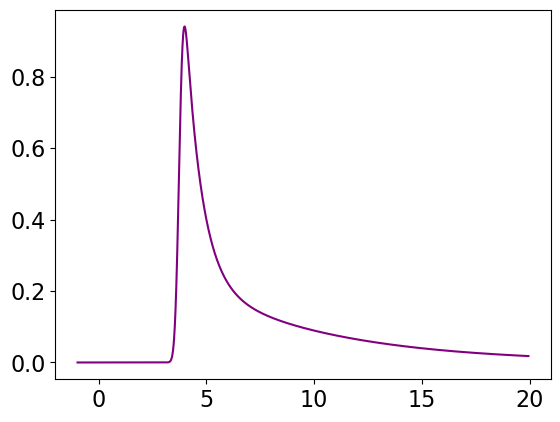

In [325]:
plt.plot(fit_time2[fit_sort2],jackman2(fit_time2,(A_i,B_i,C_i,D1_i,D2_i,f1_i))[fit_sort2],label='Jackman_guess',color='purple')

(-0.15, 1.5)

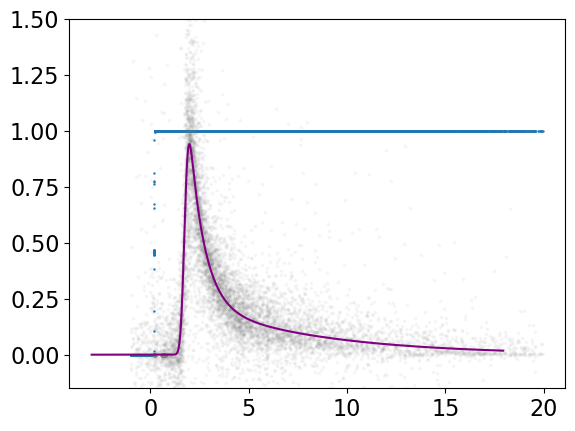

In [327]:
plt.scatter(fit_time2, (0.5*(special.erf((fit_time2-0.2)*100) + 1)),s=0.5)
plt.plot(fit_time2[fit_sort2]-2,jackman2(fit_time2,(A_i,B_i,C_i,D1_i,D2_i,f1_i))[fit_sort2],label='Jackman_guess',color='purple')
plt.scatter(fit_time2[fit_sort2],fit_flux2[fit_sort2],alpha=0.05,s=10,marker='.',color='grey')
plt.ylim(-0.15,1.5)

In [337]:
initial2 = np.array([A_i,B_i,C_i,D1_i,D2_i,f1_i])
nwalkers2= 256 #2**8
ndim2=len(initial2)


pos2 = [np.array(initial2) + 1e-4 *np.random.rand(ndim2) for i in range(nwalkers2)]

In [146]:
#print(fit_flux)
#print(fit_time)
#print(fit_both_errors)

[-0.06852156 -0.07647658 -0.10475665 ...  0.00068399 -0.04630284
 -0.05342419]
[-4.71898879e-01  1.35609789e-03  4.74680719e-01 ...  9.71801446e+00
  9.87062089e+00  1.00232273e+01]
[7.69756881e-07 7.51743651e-07 7.36771201e-07 ... 2.89323328e-07
 2.89313895e-07 2.89354442e-07]


In [338]:
#edit time and flux variables 
data = (fit_time2[fit_sort2]+2,fit_flux2[fit_sort2],fit_both_errors2[fit_sort2])
#coords= np.random.randn(500, 6)
sampler2 = emcee.EnsembleSampler(nwalkers2, ndim2, lnprob2, args=data)#,backend=backend)


sampler2.run_mcmc(pos2, 10000, progress=True);

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 10000/10000 [32:38<00:00,  5.11it/s] 


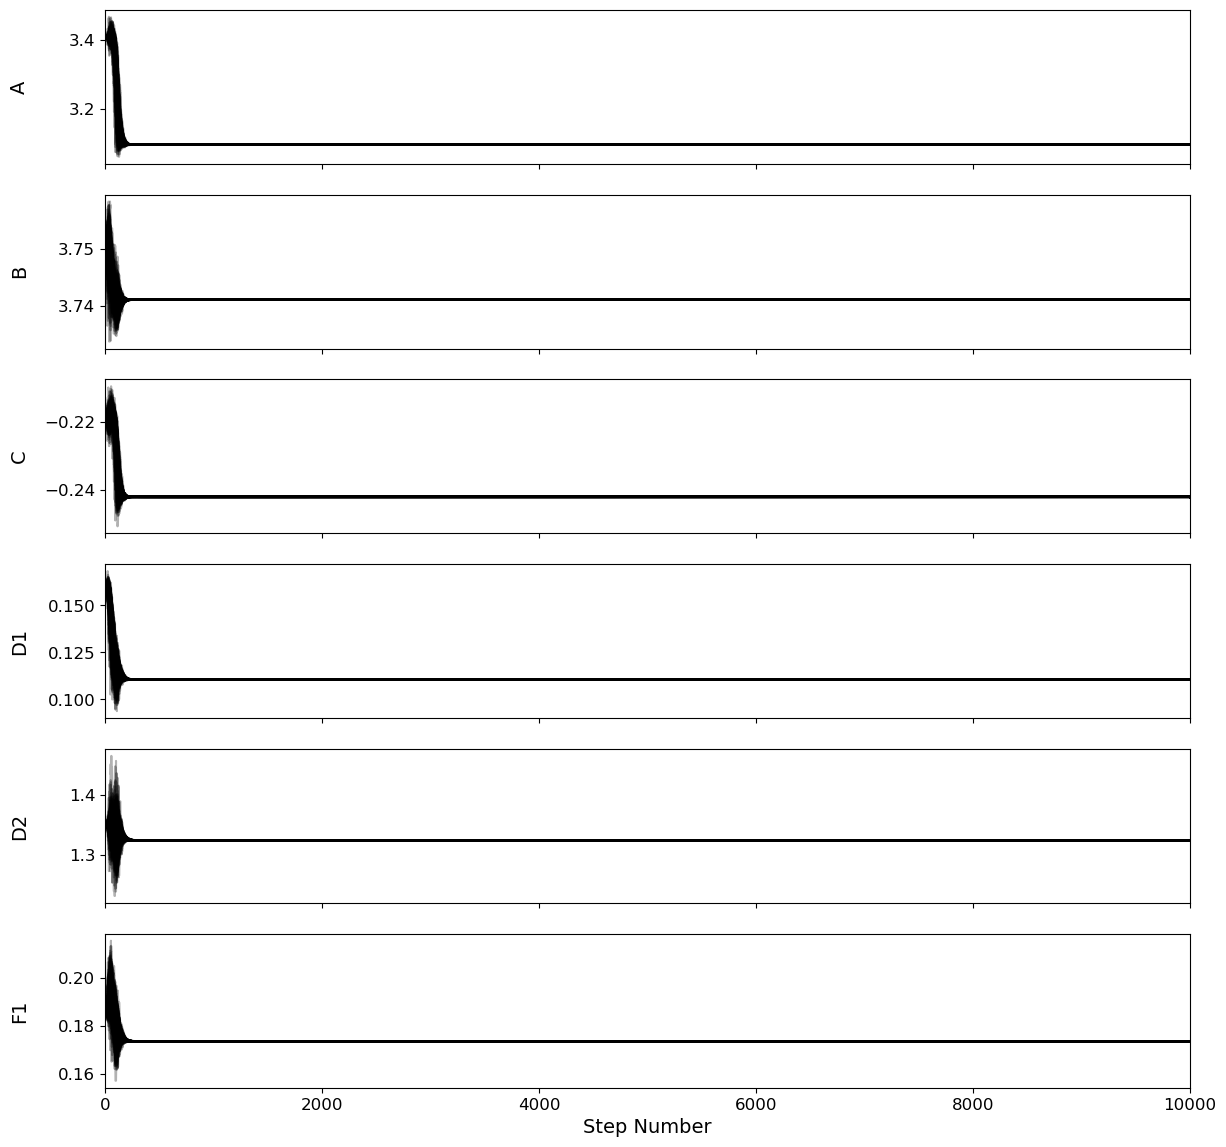

In [339]:
plt.style.use('default')
fig, axes = plt.subplots(6, figsize=(14, 14), sharex=True)
samples2 = sampler2.get_chain()
labels2 = ["A","B","C","D1","D2","F1"]
for i in range(ndim2):
    ax = axes[i]
    ax.plot(samples2[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples2))
    ax.set_ylabel(labels2[i],fontsize=14)
    ax.yaxis.set_label_coords(-.07,.5)
    ax.tick_params(axis='x',labelsize=12)
    ax.tick_params(axis='y',labelsize=12)


axes[-1].set_xlabel("Step Number",fontsize=14);

(153600, 6)


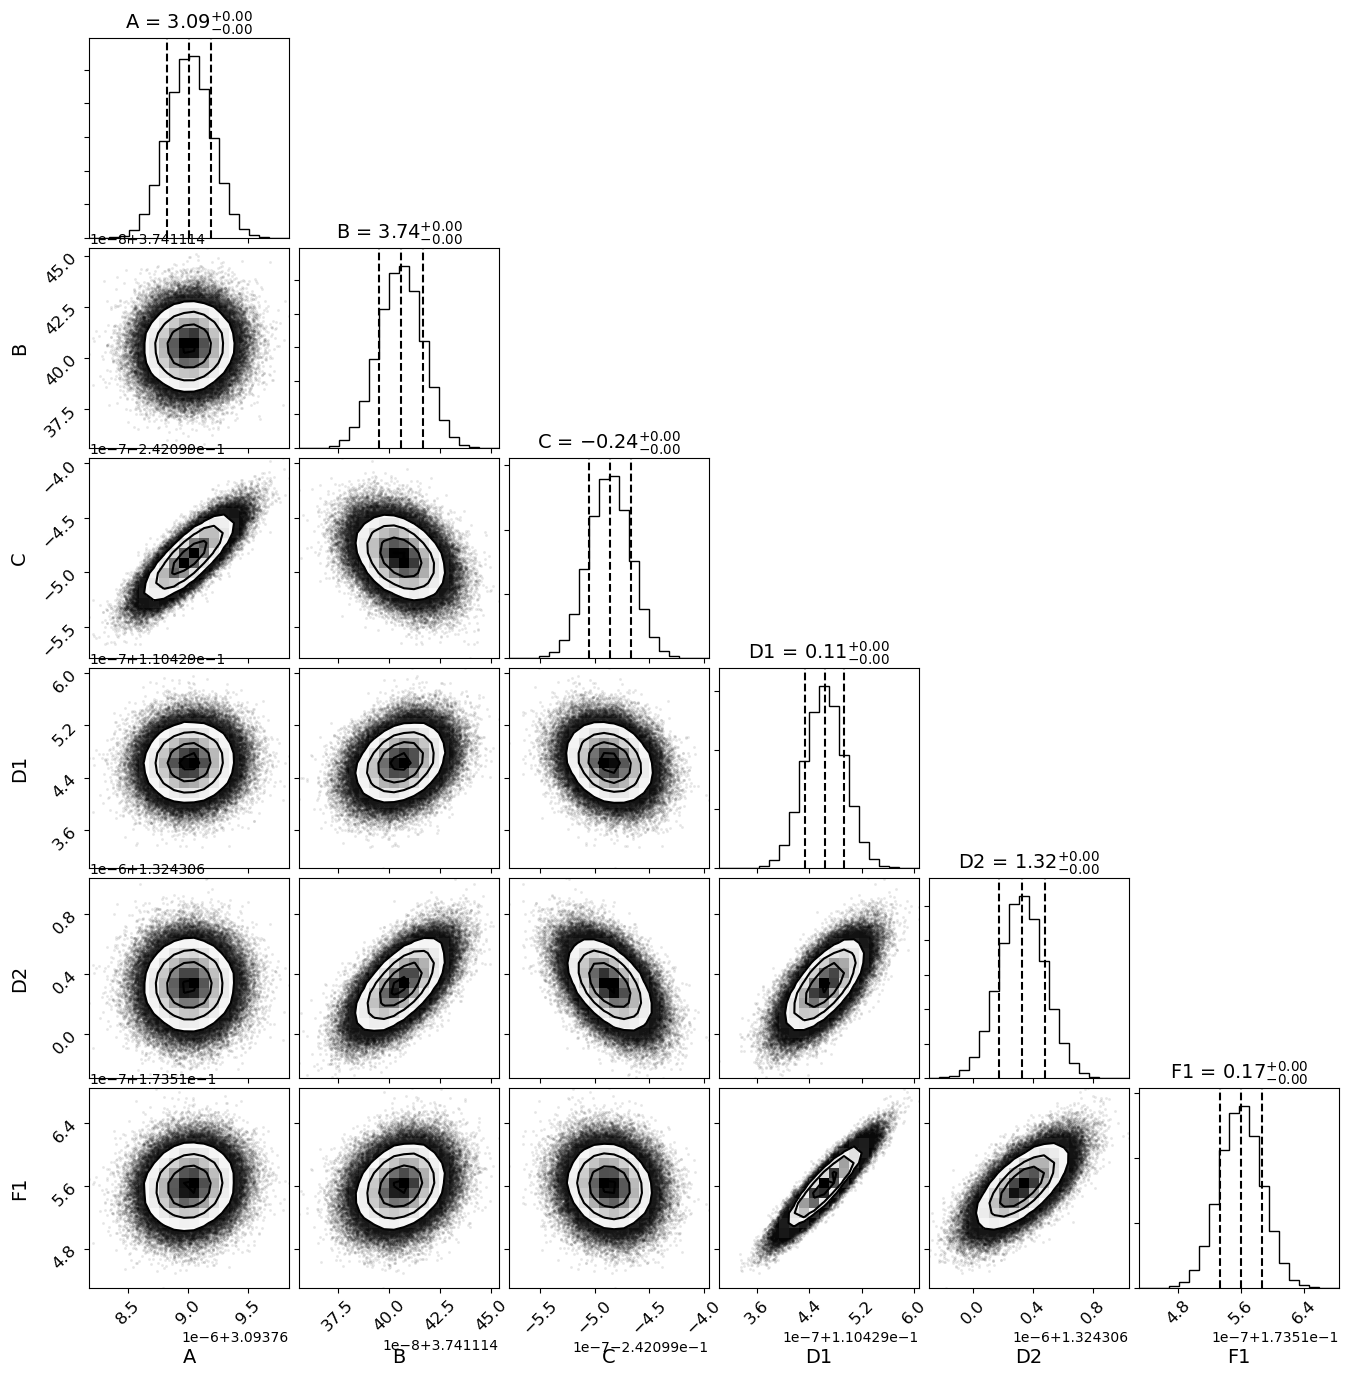

In [341]:

flat_samples2 = sampler2.get_chain(discard=1000, thin=15, flat=True)
#discard the first 10% for longer runs
print(flat_samples2.shape)

fig = corner.corner(
    flat_samples2, labels=labels2,label_kwargs={"fontsize":14},quantiles=[0.16, 0.5, 0.84],show_titles=True, title_kwargs={"fontsize": 14},
    max_n_ticks=4
);
for ax in fig.get_axes():
    #fig.subplots_adjust(left=.001,bottom=.01)
    ax.tick_params(axis='both', labelsize=12)
#plt.savefig('/Users/lupitatovar/local_flares/figures/mcmc_corner_fitting_flares_vet2.pdf')

In [342]:

print("Mean acceptance fraction: {0:.3f}"
.format(np.mean(sampler2.acceptance_fraction)))

for i in range(ndim2):
    mcmc2 = np.percentile(flat_samples2[:, i], [16, 50, 84])
    q2 = np.diff(mcmc2)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc2[1], q2[0], q2[1], labels2[i])
    display(Math(txt))

Mean acceptance fraction: 0.508


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [343]:
print(np.median(flat_samples2,axis=0))
#previous mcmc values with V0 vetted flares [ 3.4088527   3.7477446  -0.21710297  0.16109175  1.35048381  0.18575378]

[ 3.09376901  3.74111441 -0.24209949  0.11042946  1.32430633  0.17351056]


Note: previous mcmc values with V0 vetted flares [ 3.4088527   3.7477446  -0.21710297  0.16109175  1.35048381  0.18575378] and an acceptance rate of 0.510

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in multiply


Text(0, 0.5, 'Relative Flux')

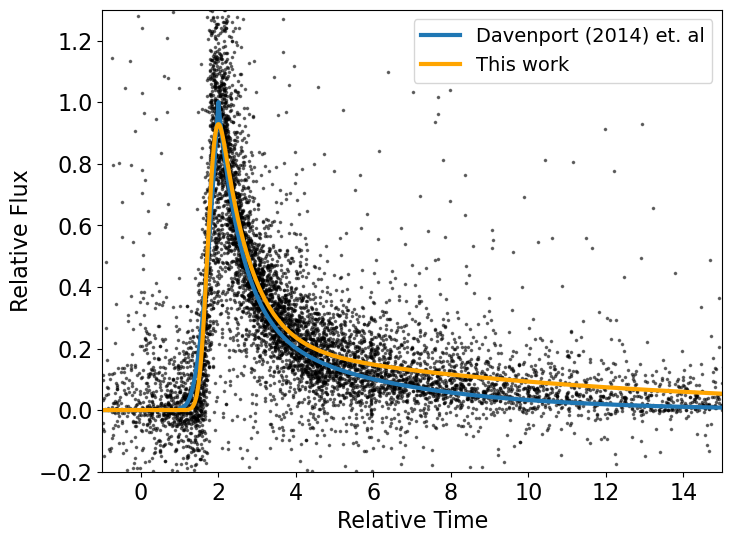

In [356]:
#shift things to be aligned at 0

plt.figure(figsize=(8, 6))
font = {'size'   : 16}
plt.rc('font', **font)
plt.plot(time_v2[v2_sort]+2,aflare1(time_v2,0,1,1)[v2_sort],color='C0',label='Davenport (2014) et. al',lw=3)
#plt.plot(fit_time[fit_sort],jim_model[fit_sort],color='black',label='Davenport (2014) et. al')
plt.plot(fit_time2[fit_sort2]-2,jackman2(fit_time2,(np.median(flat_samples2,axis=0)))[fit_sort2],label='This work',color='orange',lw=3)
#plt.plot(time[ns_all],jackman2(time,(0.91780987, 1.72326426, 0.25978216, 0.81791936, 72.63673096, 2.76862114))[ns_all],label='Jims vals',color='orange')
plt.scatter(fit_time2[fit_sort2],fit_flux2[fit_sort2],alpha=0.5,s=10,marker='.',color='black')
#plt.xlim(-4,5)
plt.ylim(-0.2,1.3)
plt.xlim(-1,15)
plt.legend(loc='upper right',fontsize=14)
plt.xlabel('Relative Time')
plt.ylabel('Relative Flux')
#plt.savefig('/Users/lupitatovar/local_flares/figures/new_stack_procedure_comparison2.pdf')

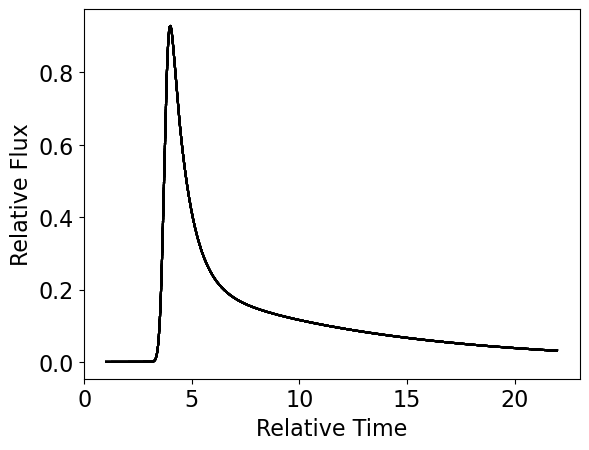

In [345]:

# plot this into notebook to plot samples from posterior distribution
inds = np.random.randint(len(flat_samples2), size=100)
for ind in inds:
    sample = flat_samples2[ind]
    plt.plot(fit_time[fit_sort]+2, jackman2(fit_time[fit_sort]+2, [*sample]), "k", alpha=0.1)
    plt.xlabel('Relative Time')
    plt.ylabel('Relative Flux')

### Flare Model Version 2

In [357]:
def flare_model_v2(t,tpeak, fwhm, ampl):

    t_new = (t-tpeak)/fwhm +2


    #Values were fit & calculated using MCMC 256 walkers and 10000 steps

    A,B,C,D1,D2,f1 = [3.09376901,  3.74111441, -0.24209949,  0.11042946,  1.32430633,  0.17351056]
    z1 = ((2*B + (C**2 *D1))/(2*C))
    z2 = ((2*B + C**2 *D2)/(2*C))
    f2 = 1-f1
    flare = (1/2) * np.sqrt(np.pi) * A * C * ((f1 * np.exp((D1*(B-t_new)) + ((C**2 * D1**2)/4))*(special.erf(z1) - special.erf(z1 - (t_new/C))))
                                             + (f2 * np.exp((D2*(B-t_new)) + ((C**2 * D2**2)/4))*(special.erf(z2) - special.erf(z2 - (t_new/C)))))
    return flare * ampl

Flare Model V1: Uses old stacking procedure and mcmc values from double_exp_emcee_fit1.ipynb

Flare Model V2: Vetting round 2 of flares, and new stacking procedure

(-1.0, 15.0)

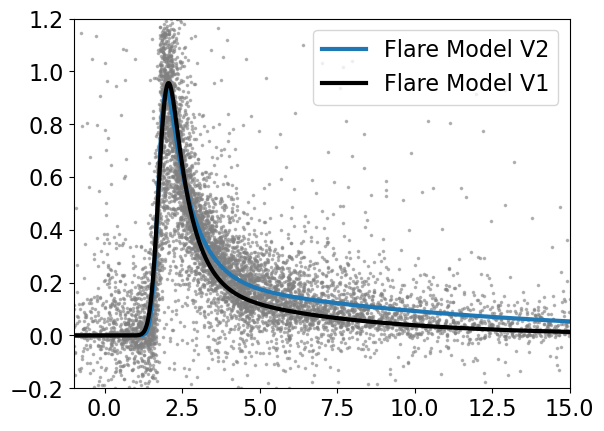

In [368]:
plt.plot(time_v2[v2_sort],flare_model_v2(time_v2,0,1,1)[v2_sort],color='C0',label='Flare Model V2',lw=3)
plt.plot(time_v2[v2_sort],flare_model(time_v2,0,1,1)[v2_sort],color='black',label='Flare Model V1',lw=3)
plt.scatter(fit_time2[fit_sort2],fit_flux2[fit_sort2],alpha=0.5,s=10,marker='.',color='grey')
plt.legend()
plt.ylim(-0.2,1.2)
plt.xlim(-1,15)

Testing out new stacking procedure

Computing $\chi ^2$ of the data vs the new flare model below:

In [369]:
print(xmin)
print(xmax)
print(ymin)
print(ymax)

-1
5
-0.5
1.5


In [370]:
both_mask_v2 = np.where((time_v2[v2_sort] > xmin) & (time_v2[v2_sort] < xmax) & (flux_v2[v2_sort] > ymin) & (flux_v2[v2_sort] < ymax))[0]
print(len(both_mask_v2))

9085
244.7603947637945


In [375]:
#Flare Model V1 with round 1 of vetted flares (558)
v1_f1 =(np.nansum(((flux[ns_all][both_mask]- flare_model(time[ns_all],0,1,1.2)[both_mask])/both_errors[ns_all][both_mask])**2)/(len(both_mask)))
print('Chi Squared Flare Model V1 with Rd1 vetting of flares: ' + str(v1_f1))

Chi Squared Flare Model V1 with Rd1 vetting of flares: 551.8367826526974


In [372]:
#Flare Model V1 with round 2 of vetted flares (302)
v1_f2 = (np.nansum(((flux_v2[v2_sort][both_mask_v2]- flare_model(time_v2[v2_sort],0,1,1.2)[both_mask_v2])/both_errors_v2[v2_sort][both_mask_v2])**2)/(len(both_mask_v2)))
print('Chi Squared Flare Model V1 with Rd2 vetting of flares: ' + str(v1_f2))

Chi Squared Flare Model V1 with Rd2 vetting of flares:244.7603947637945


In [374]:
#Flare Model V2
v2_f2 = (np.nansum(((flux_v2[v2_sort][both_mask_v2]- flare_model_v2(time_v2[v2_sort],0,1,1.2)[both_mask_v2])/both_errors_v2[v2_sort][both_mask_v2])**2)/(len(both_mask_v2)))
print('Chi Squared Flare Model V2 new stacking procedure: ' + str(v2_f2))

Chi Squared Flare Model V2 new stacking procedure: 243.1786445525747


New figures